Fetching data for AAPL from 2022-06-06 to 2024-06-05
Fetched data for AAPL
Fetching data for ABBV from 2022-06-06 to 2024-06-05
Fetched data for ABBV
Fetching data for ADBE from 2022-06-06 to 2024-06-05
Fetched data for ADBE
Fetching data for AMZN from 2022-06-06 to 2024-06-05
Fetched data for AMZN
Fetching data for AVGO from 2022-06-06 to 2024-06-05
Fetched data for AVGO
Fetching data for BRK-B from 2022-06-06 to 2024-06-05
Fetched data for BRK-B
Fetching data for CRM from 2022-06-06 to 2024-06-05
Fetched data for CRM
Fetching data for COST from 2022-06-06 to 2024-06-05
Fetched data for COST
Fetching data for CVX from 2022-06-06 to 2024-06-05
Fetched data for CVX
Fetching data for HD from 2022-06-06 to 2024-06-05
Fetched data for HD
Fetching data for JNJ from 2022-06-06 to 2024-06-05
Fetched data for JNJ
Fetching data for JPM from 2022-06-06 to 2024-06-05
Fetched data for JPM
Fetching data for LLY from 2022-06-06 to 2024-06-05
Fetched data for LLY
Fetching data for MA from 2022-06-06 

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Target Risk: 0.05, Volatility: 0.09925980096959044, Return: 0.0813318676807375
Target Risk: 0.05408163265306123, Volatility: 0.0992598008818141, Return: 0.08132778628966503
Target Risk: 0.05816326530612245, Volatility: 0.09925980062892317, Return: 0.08132422608196899
Target Risk: 0.06224489795918368, Volatility: 0.0992598005374397, Return: 0.08131995098350855
Target Risk: 0.0663265306122449, Volatility: 0.09925980033961122, Return: 0.08131600601102519
Target Risk: 0.07040816326530613, Volatility: 0.09925980022700173, Return: 0.08131198851544266
Target Risk: 0.07448979591836735, Volatility: 0.09925980011380671, Return: 0.08130789380720735
Target Risk: 0.07857142857142857, Volatility: 0.09925980003380046, Return: 0.08130342145332752
Target Risk: 0.0826530612244898, Volatility: 0.09925979995483904, Return: 0.08129946973945071
Target Risk: 0.08673469387755103, Volatility: 0.09925979989046904, Return: 0.08129509786805468
Target Risk: 0.09081632653061225, Volatility: 0.09925979984846989, Ret

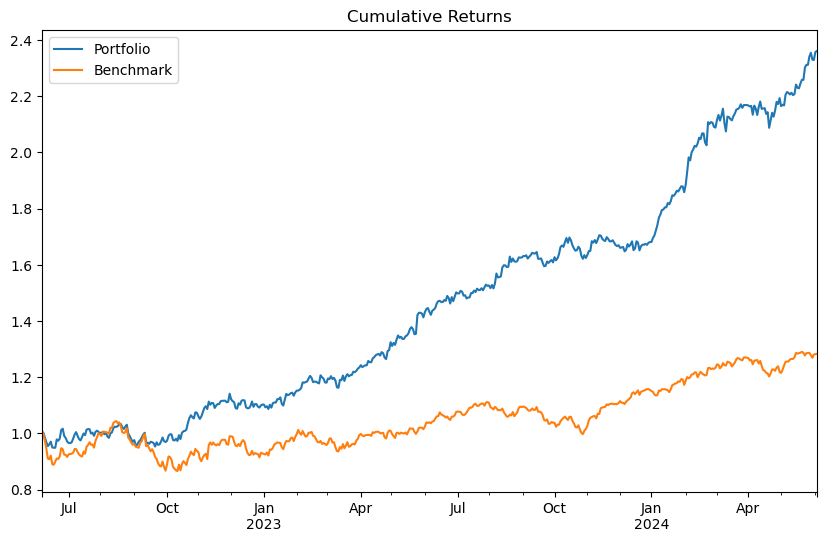

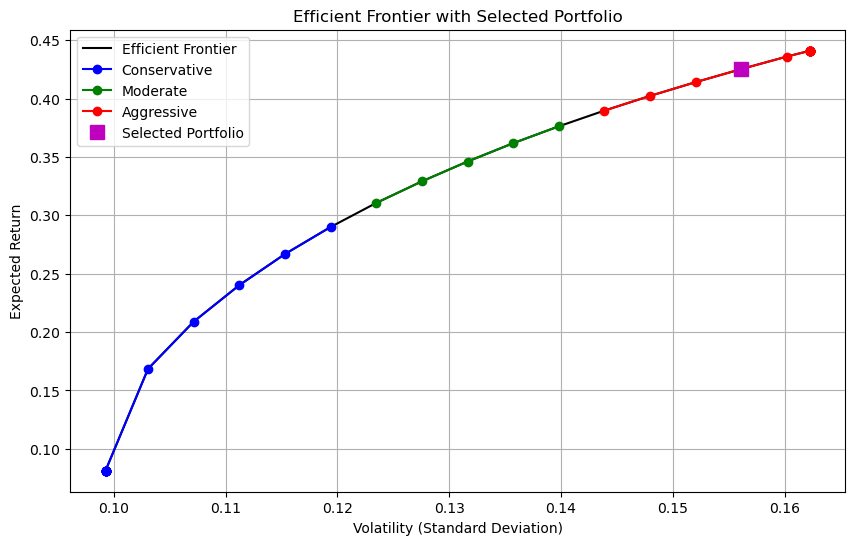

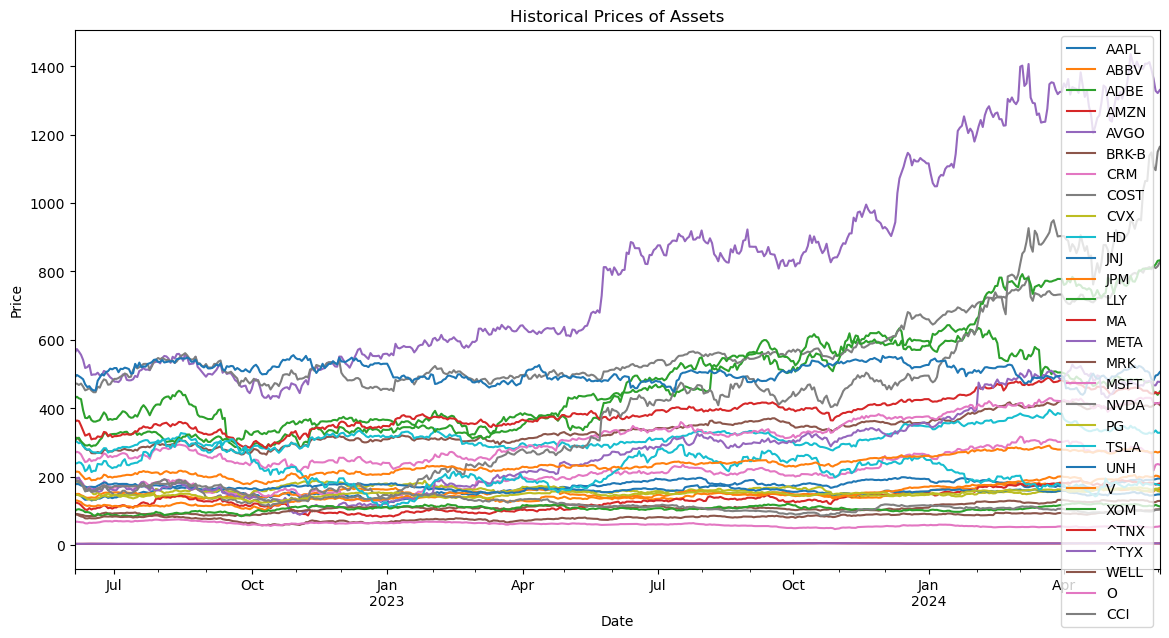

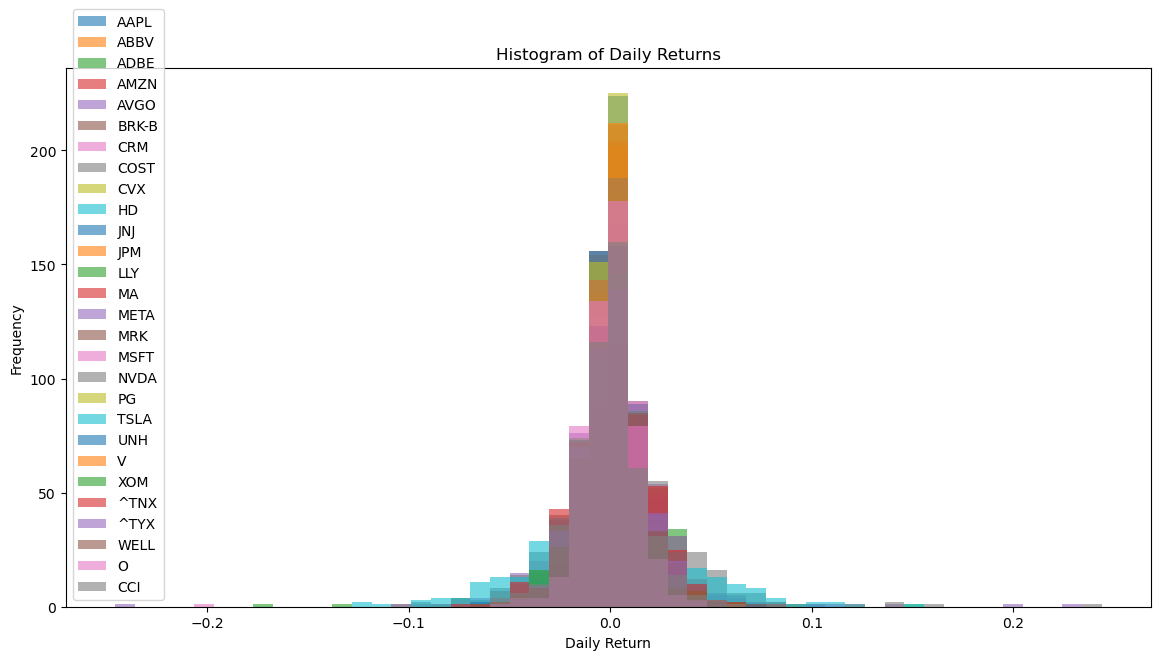

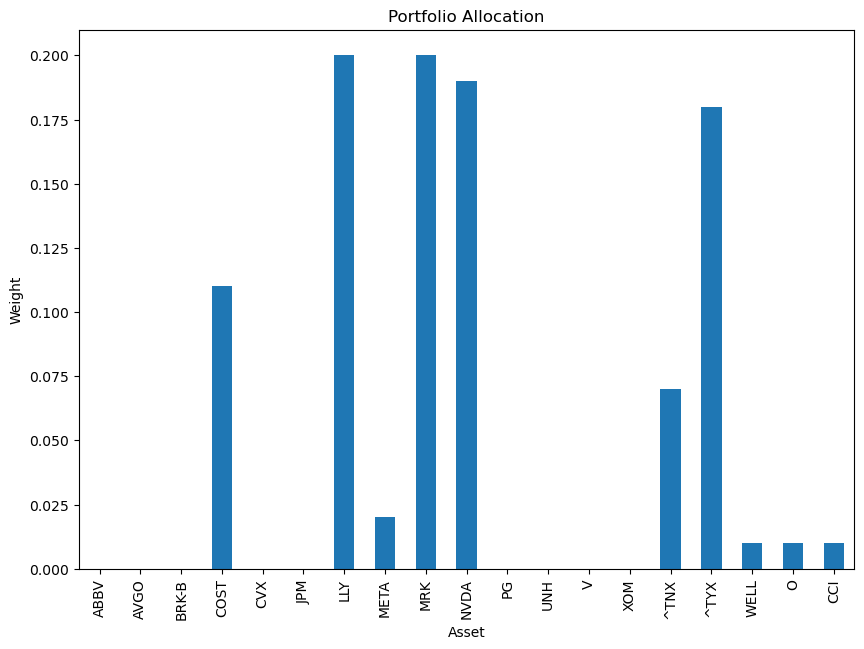

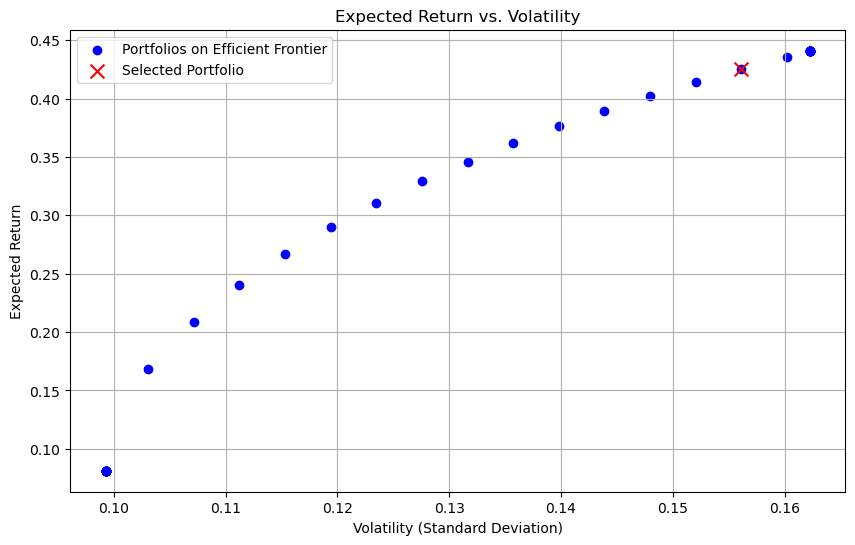

In [14]:
import numpy as np
import pandas as pd
import yahoo_fin.stock_info as si
from scipy.optimize import minimize
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Define the assets
stocks = ["AAPL", "ABBV", "ADBE", "AMZN", "AVGO", "BRK-B", "CRM", "COST", "CVX", "HD", 
          "JNJ", "JPM", "LLY", "MA", "META", "MRK", "MSFT", "NVDA", "PG", "TSLA", "UNH", "V", "XOM"]
bonds = ["^TNX", "^TYX"]
reits = ["WELL", "O", "CCI"]

assets = stocks + bonds + reits

# Set date range for the past 10 years
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y-%m-%d')

# Fetch historical data
data = {}
failed_assets = []
for asset in assets:
    try:
        print(f"Fetching data for {asset} from {start_date} to {end_date}")
        data[asset] = si.get_data(asset, start_date=start_date, end_date=end_date)['close']
        print(f"Fetched data for {asset}")
    except Exception as e:
        print(f"Failed to fetch data for {asset}: {e}")
        failed_assets.append(asset)

# Create a DataFrame from the fetched data
price_df = pd.DataFrame(data)

# Fill missing values by forward filling
price_df = price_df.ffill()

# Print the DataFrame to verify
print("Price DataFrame Head:")
print(price_df.head())
print("Price DataFrame Tail:")
print(price_df.tail())

# Drop columns with missing values
price_df = price_df.dropna(axis=1)

# Adjust the assets list based on successfully fetched data
valid_assets = price_df.columns.tolist()

# Ensure there are valid assets before proceeding
if len(valid_assets) == 0:
    raise ValueError("No valid assets fetched. Please check your asset list and data fetching process.")

# Calculate daily returns
returns_df = price_df.pct_change().dropna()
# Display the head and tail of returns_df to verify
print("Returns DataFrame Head:")
print(returns_df.head())
print("Returns DataFrame Tail:")
print(returns_df.tail())


# Calculate expected returns and covariance matrix
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Define normalization and composite risk profile calculation functions
def normalize_risk_tolerance_score(risk_tolerance_score):
    return risk_tolerance_score  # Assuming risk_tolerance_score is already between 0 and 1

def calculate_composite_risk_profile(risk_capacity, risk_tolerance_score):
    normalized_risk_tolerance_score = normalize_risk_tolerance_score(risk_tolerance_score)
    composite_risk_profile = (risk_capacity + normalized_risk_tolerance_score) / 2
    return composite_risk_profile

# def map_composite_risk_profile_to_target_risk(composite_risk_profile):
#     if composite_risk_profile <= 0.33:
#         # Conservative portfolio
#         min_risk_level = 0.05
#         max_risk_level = 0.10
#     elif composite_risk_profile <= 0.67:
#         # Balanced portfolio
#         min_risk_level = 0.10
#         max_risk_level = 0.15
#     else:
#         # Aggressive portfolio
#         min_risk_level = 0.15
#         max_risk_level = 0.30

#     return min_risk_level + (max_risk_level - min_risk_level) * (composite_risk_profile % 0.33)

def map_composite_risk_profile_to_target_risk(composite_risk_profile, min_risk_level=0.05, max_risk_level=0.20):
    return min_risk_level + (max_risk_level - min_risk_level) * composite_risk_profile
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * 252)
    return returns, std

def minimize_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# Objective function to maximize the Sharpe ratio and target risk level
def objective_function(weights, mean_returns, cov_matrix, risk_free_rate, target_risk):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = minimize_volatility(weights, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    penalty = abs(portfolio_volatility - target_risk)
    return -sharpe_ratio + penalty  # Negative to maximize Sharpe ratio and penalty to target risk level

# Get optimal weights based on the target risk level
def get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate, target_risk)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights must be 1
        {'type': 'ineq', 'fun': lambda x: target_risk - minimize_volatility(x, cov_matrix)}  # Ensure portfolio risk <= target risk
    )
    # bounds = tuple((0, 0.20) for asset in range(num_assets))  # Enforce diversification
    # Adjust bounds to ensure some allocation to REITs
    bounds = []
    for asset in assets:
        if asset in reits:
            bounds.append((0.01, 0.20))  # Ensure at least 1% allocation to REITs
        else:
            bounds.append((0, 0.20))
    bounds = tuple(bounds)

    result = minimize(objective_function, num_assets * [1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Define a function to calculate portfolios for a range of risk levels
def calculate_efficient_frontier(mean_returns, cov_matrix, risk_free_rate, num_portfolios=50):
    target_risks = np.linspace(0.05, 0.25, num_portfolios)  # Define a range of target risks
    portfolios = []

    for target_risk in target_risks:
        weights = get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk)
        returns, std = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        print(f"Target Risk: {target_risk}, Volatility: {std}, Return: {returns}")
        portfolios.append((std, returns, weights))

    return portfolios

# Define user information and risk tolerance
user_age = 30
investment_horizon = 20  # years
investment_amount = 10000  # in dollars
user_income = 75000  # annual income in dollars
risk_tolerance_score = 0.66 # 0.0 (very low) to 1.0 (very high)
risk_capacity = 0.75 # Example risk capacity

# Calculate the composite risk profile
composite_risk_profile = calculate_composite_risk_profile(risk_capacity, risk_tolerance_score)
print(f"Composite Risk Profile: {composite_risk_profile}")

# Map composite risk profile to target risk level
target_risk = map_composite_risk_profile_to_target_risk(composite_risk_profile)
print(f"Target Risk Level: {target_risk}")

# Define the risk-free rate (using the 10-year Treasury yield as a proxy)
risk_free_rate = si.get_data("^TNX")['close'].iloc[-1] / 100
print(f"Risk-Free Rate: {risk_free_rate}")


# Calculate the efficient frontier
efficient_frontier = calculate_efficient_frontier(mean_returns, cov_matrix, risk_free_rate)

# Automatically select the best portfolio based on the target risk level
selected_portfolio = min(efficient_frontier, key=lambda x: abs(x[0] - target_risk))
selected_weights = selected_portfolio[2]

# Filter out assets with non-zero weights
non_zero_weights = selected_weights[selected_weights > 0]
non_zero_assets = np.array(valid_assets)[selected_weights > 0]

# Normalize the weights to sum up to 1 (100%)
normalized_weights = non_zero_weights / np.sum(non_zero_weights)

# Round the weights to two decimal places
rounded_weights = np.round(normalized_weights, 2)

# Adjust the weights to ensure they sum to 1 after rounding
diff = 1.0 - np.sum(rounded_weights)
rounded_weights[np.argmax(rounded_weights)] += diff

# Create a DataFrame for the filtered and normalized portfolio
optimal_portfolio = pd.DataFrame({'Asset': non_zero_assets, 'Weight': rounded_weights})

# Display the filtered and normalized portfolio allocation
print(optimal_portfolio)

# Calculate the expected return and volatility of the optimal portfolio
optimal_return, optimal_volatility = portfolio_annualized_performance(rounded_weights, mean_returns.loc[non_zero_assets], cov_matrix.loc[non_zero_assets, non_zero_assets])
sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

print(f"Expected Portfolio Return: {optimal_return * 100:.2f}%")
print(f"Expected Portfolio Volatility: {optimal_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Categorize the assets based on their types
portfolio_stocks = []
portfolio_bonds = []
portfolio_reits = []

for asset, weight in zip(non_zero_assets, rounded_weights):
    if asset in stocks:
        portfolio_stocks.append((asset, weight))
    elif asset in bonds:
        portfolio_bonds.append((asset, weight))
    elif asset in reits:
        portfolio_reits.append((asset, weight))

# Display the user's portfolio in array format
user_portfolio = {
    "Stocks": portfolio_stocks,
    "Bonds": portfolio_bonds,
    "REITs": portfolio_reits
}

# Calculate the total amount allocated to each asset class
total_stocks = sum(weight for asset, weight in user_portfolio["Stocks"])
total_bonds = sum(weight for asset, weight in user_portfolio["Bonds"])
total_reits = sum(weight for asset, weight in user_portfolio["REITs"])

amount_stocks = total_stocks * investment_amount
amount_bonds = total_bonds * investment_amount
amount_reits = total_reits * investment_amount

print("User's Portfolio:")
print("Stocks:", user_portfolio["Stocks"])
print("Bonds:", user_portfolio["Bonds"])
print("REITs:", user_portfolio["REITs"])

print("\nInvestment Amount Allocation:")
print(f"Total Investment Amount: ${investment_amount}")
print(f"Amount in Stocks: ${amount_stocks:.2f}")
print(f"Amount in Bonds: ${amount_bonds:.2f}")
print(f"Amount in REITs: ${amount_reits:.2f}")

# --- Start of Backtesting Section ---

# Fetch benchmark data (e.g., S&P 500 index)
benchmark_data = si.get_data('SPY', start_date=start_date, end_date=end_date)['close']
benchmark_returns = benchmark_data.pct_change().dropna()

# Calculate portfolio returns based on optimized weights
portfolio_returns = returns_df[non_zero_assets].dot(rounded_weights)

# Calculate performance metrics
def calculate_performance_metrics(portfolio_returns, benchmark_returns, risk_free_rate=0.01):
    metrics = {}
    
    # Align the dates of portfolio returns and benchmark returns
    aligned_returns = portfolio_returns.align(benchmark_returns, join='inner')
    portfolio_returns, benchmark_returns = aligned_returns[0], aligned_returns[1]

    # Annualized Return
    annualized_return = np.mean(portfolio_returns) * 252
    benchmark_annualized_return = np.mean(benchmark_returns) * 252

    # Volatility (Standard Deviation)
    volatility = np.std(portfolio_returns) * np.sqrt(252)
    benchmark_volatility = np.std(benchmark_returns) * np.sqrt(252)

    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility
    benchmark_sharpe_ratio = (benchmark_annualized_return - risk_free_rate) / benchmark_volatility

    # Maximum Drawdown
    cumulative_returns = (1 + portfolio_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    # Alpha and Beta
    cov_matrix = np.cov(portfolio_returns, benchmark_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    alpha = annualized_return - (risk_free_rate + beta * (benchmark_annualized_return - risk_free_rate))

    metrics = {
        'Annualized Return': annualized_return,
        'Benchmark Annualized Return': benchmark_annualized_return,
        'Volatility': volatility,
        'Benchmark Volatility': benchmark_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Benchmark Sharpe Ratio': benchmark_sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Alpha': alpha,
        'Beta': beta
    }

    return metrics

# Calculate and print performance metrics
metrics = calculate_performance_metrics(portfolio_returns, benchmark_returns, risk_free_rate)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot cumulative returns
plt.figure(figsize=(10, 6))
(1 + portfolio_returns).cumprod().plot(label='Portfolio')
(1 + benchmark_returns).cumprod().plot(label='Benchmark')
plt.title('Cumulative Returns')
plt.legend()
plt.show()

# --- End of Backtesting Section ---

# Split the efficient frontier into conservative, moderate, and aggressive sections based on dynamic thresholds
min_volatility = min(p[0] for p in efficient_frontier)
max_volatility = max(p[0] for p in efficient_frontier)
volatility_range = max_volatility - min_volatility

# Define dynamic thresholds
conservative_threshold = min_volatility + volatility_range / 3
moderate_threshold = min_volatility + 2 * volatility_range / 3

# Allocate the portfolios dynamically
conservative_portfolios = [p for p in efficient_frontier if p[0] <= conservative_threshold]
moderate_portfolios = [p for p in efficient_frontier if conservative_threshold < p[0] <= moderate_threshold]
aggressive_portfolios = [p for p in efficient_frontier if p[0] > moderate_threshold]

# Ensure each section has at least one portfolio
if not conservative_portfolios:
    conservative_portfolios.append(efficient_frontier[0])
if not moderate_portfolios:
    moderate_portfolios.append(efficient_frontier[len(efficient_frontier)//2])
if not aggressive_portfolios:
    aggressive_portfolios.append(efficient_frontier[-1])

# Extract weights for the first portfolio in each section
conservative_start = conservative_portfolios[0]
moderate_start = moderate_portfolios[0]
aggressive_start = aggressive_portfolios[0]

# Plot the efficient frontier with sections and the selected portfolio
plt.figure(figsize=(10, 6))
plt.plot([p[0] for p in efficient_frontier], [p[1] for p in efficient_frontier], 'k-', label='Efficient Frontier')
plt.plot([p[0] for p in conservative_portfolios], [p[1] for p in conservative_portfolios], 'bo-', label='Conservative')
plt.plot([p[0] for p in moderate_portfolios], [p[1] for p in moderate_portfolios], 'go-', label='Moderate')
plt.plot([p[0] for p in aggressive_portfolios], [p[1] for p in aggressive_portfolios], 'ro-', label='Aggressive')
plt.plot(selected_portfolio[0], selected_portfolio[1], 'ms', markersize=10, label='Selected Portfolio')  # Highlight the selected portfolio

plt.title('Efficient Frontier with Selected Portfolio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

# Plot historical prices
price_df.plot(figsize=(14, 7), title='Historical Prices of Assets')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Plot returns
returns_df.plot(kind='hist', bins=50, alpha=0.6, figsize=(14, 7), title='Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.show()

# Alternatively, a bar chart
optimal_portfolio.plot(kind='bar', x='Asset', y='Weight', legend=False, figsize=(10, 7), title='Portfolio Allocation')
plt.xlabel('Asset')
plt.ylabel('Weight')
plt.show()


# Plot the expected return and volatility of the selected portfolio
plt.figure(figsize=(10, 6))
plt.scatter([p[0] for p in efficient_frontier], [p[1] for p in efficient_frontier], c='blue', marker='o', label='Portfolios on Efficient Frontier')
plt.scatter(selected_portfolio[0], selected_portfolio[1], c='red', marker='x', s=100, label='Selected Portfolio')  # Highlight the selected portfolio

plt.title('Expected Return vs. Volatility')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()



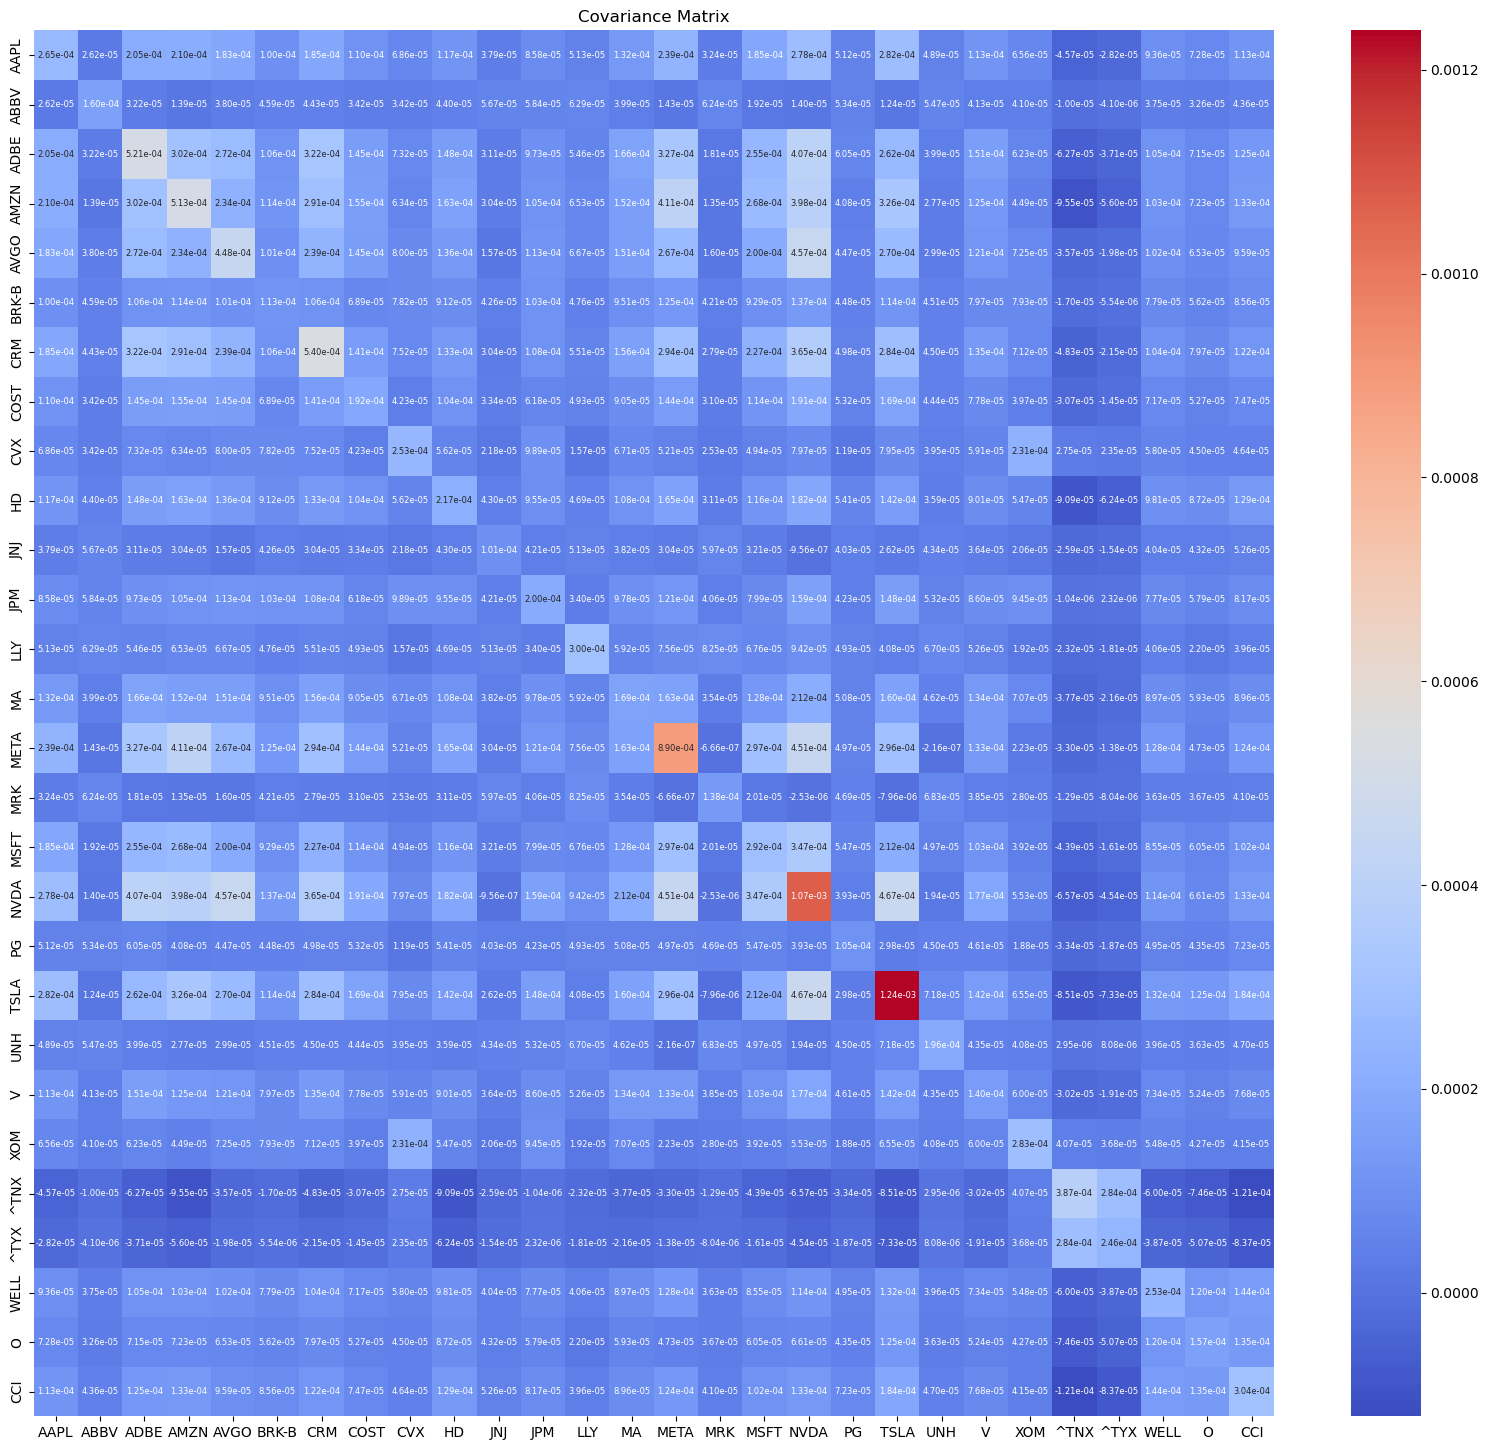

In [9]:
# Plot the covariance matrix
plt.figure(figsize=(20, 18))
sns.heatmap(cov_matrix, annot=True, fmt='.2e', cmap="coolwarm", xticklabels=valid_assets, yticklabels=valid_assets, annot_kws={"size": 6})
plt.title('Covariance Matrix')
plt.show()

### Backtesting

Fetching data for AAPL from 2022-06-06 to 2024-06-05
Fetched data for AAPL
Fetching data for ABBV from 2022-06-06 to 2024-06-05
Fetched data for ABBV
Fetching data for ADBE from 2022-06-06 to 2024-06-05
Fetched data for ADBE
Fetching data for AMZN from 2022-06-06 to 2024-06-05
Fetched data for AMZN
Fetching data for AVGO from 2022-06-06 to 2024-06-05
Fetched data for AVGO
Fetching data for BRK-B from 2022-06-06 to 2024-06-05
Fetched data for BRK-B
Fetching data for CRM from 2022-06-06 to 2024-06-05
Fetched data for CRM
Fetching data for COST from 2022-06-06 to 2024-06-05
Fetched data for COST
Fetching data for CVX from 2022-06-06 to 2024-06-05
Fetched data for CVX
Fetching data for HD from 2022-06-06 to 2024-06-05
Fetched data for HD
Fetching data for JNJ from 2022-06-06 to 2024-06-05
Fetched data for JNJ
Fetching data for JPM from 2022-06-06 to 2024-06-05
Fetched data for JPM
Fetching data for LLY from 2022-06-06 to 2024-06-05
Fetched data for LLY
Fetching data for MA from 2022-06-06 

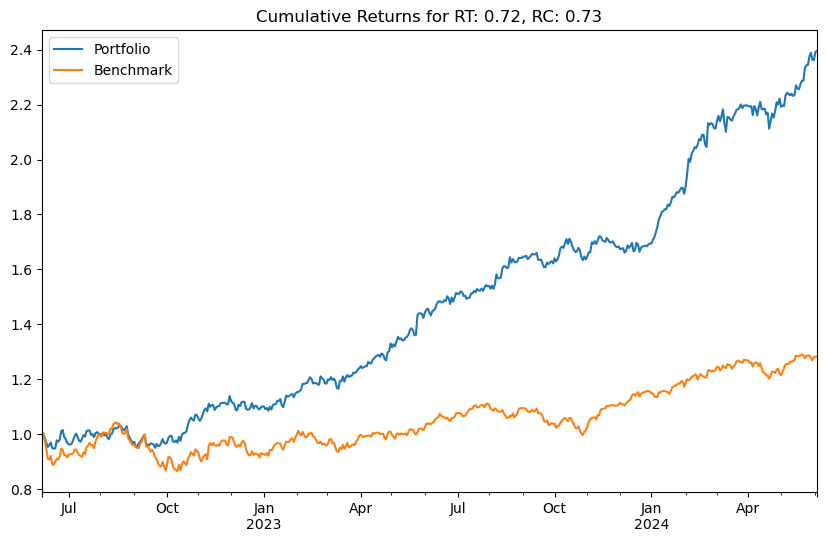

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


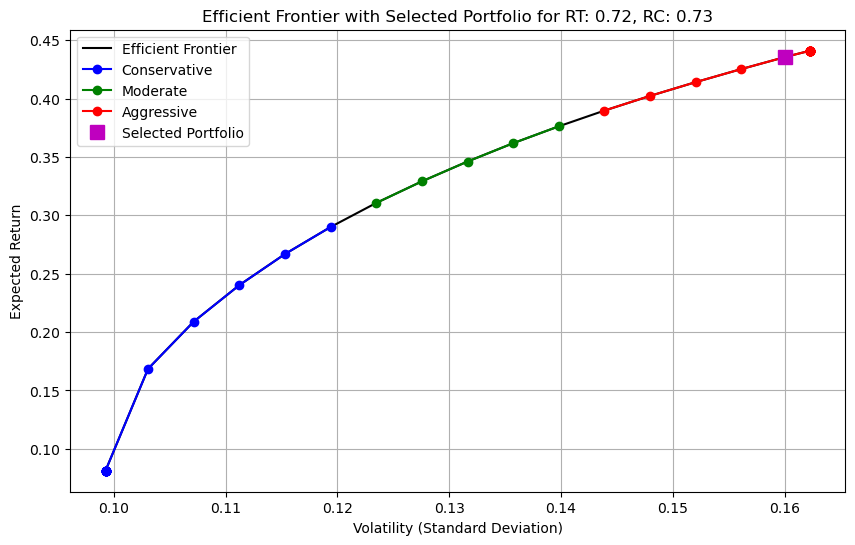

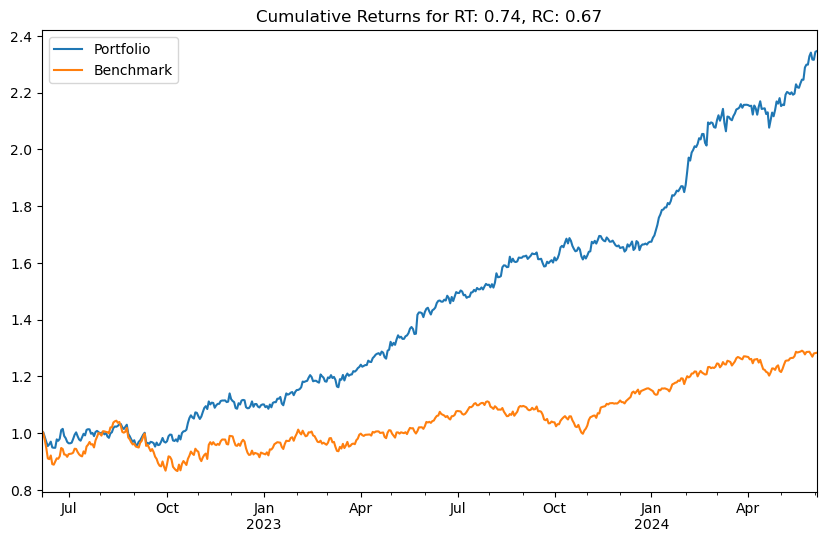

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


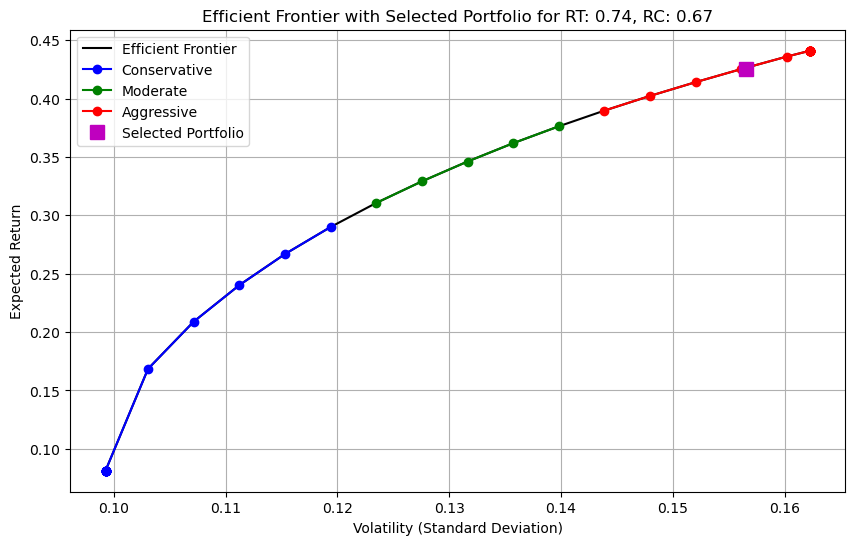

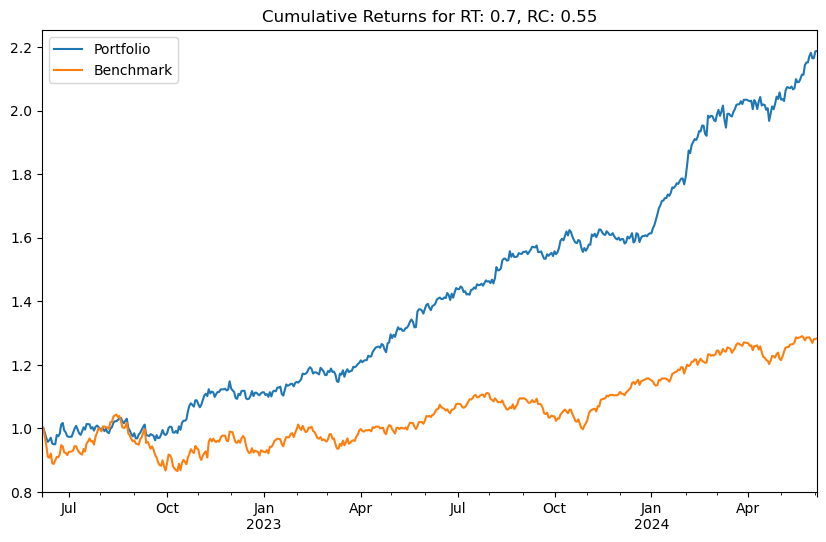

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


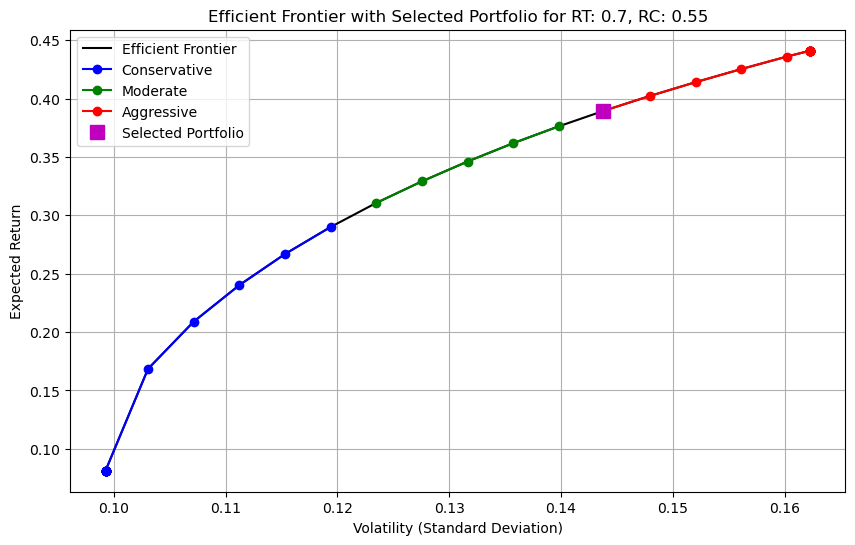

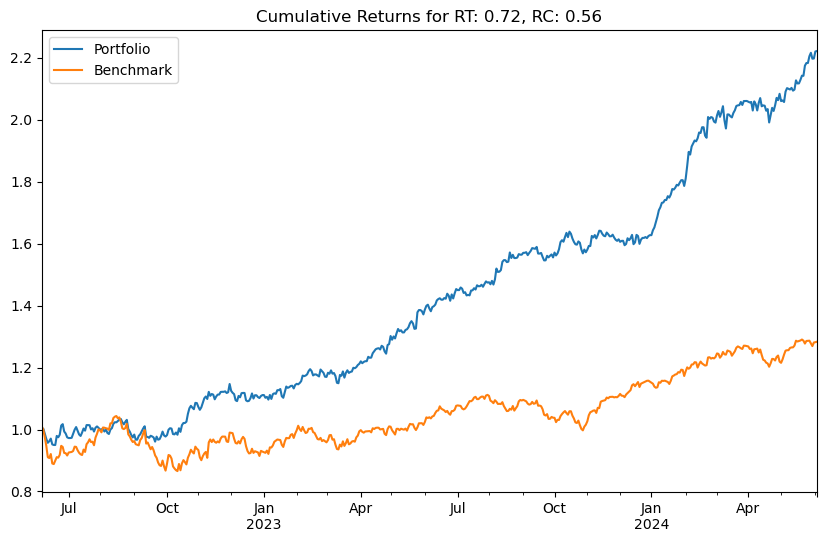

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


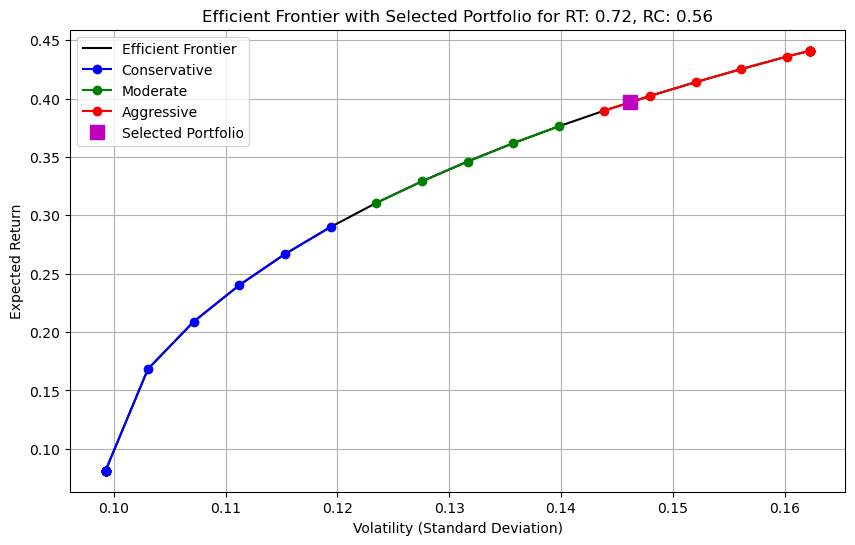

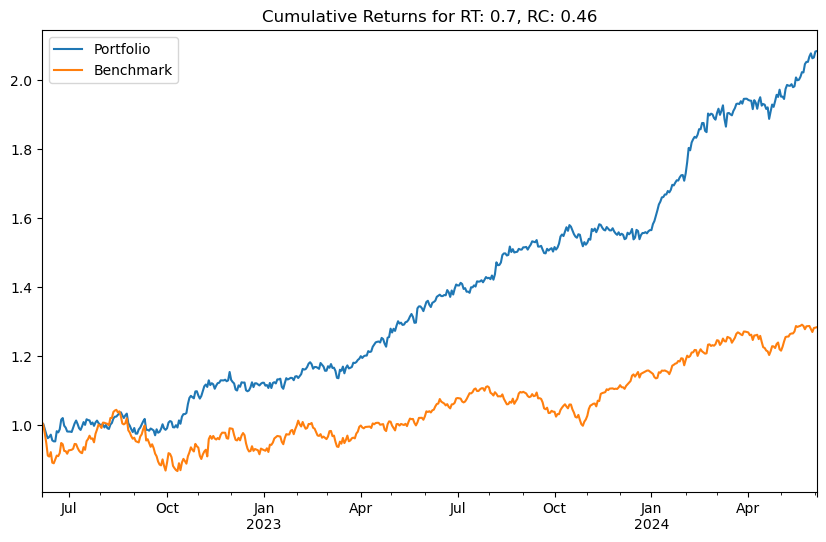

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


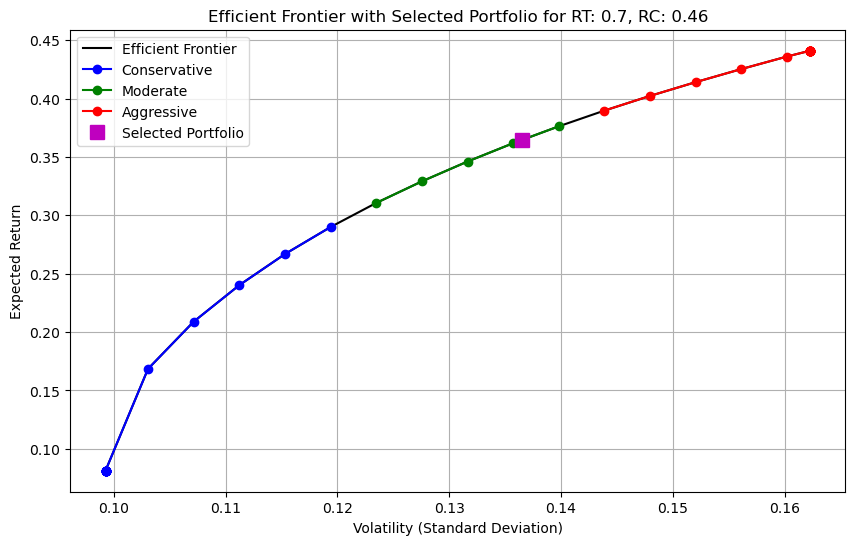

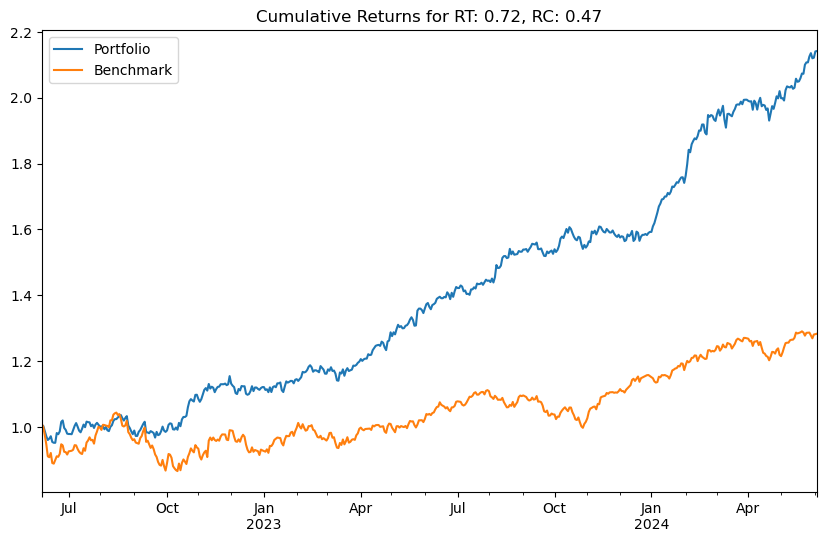

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


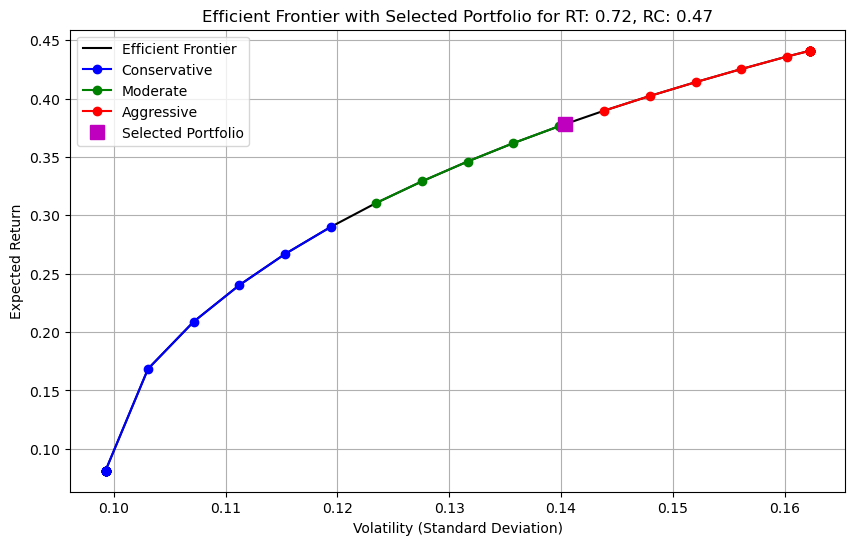

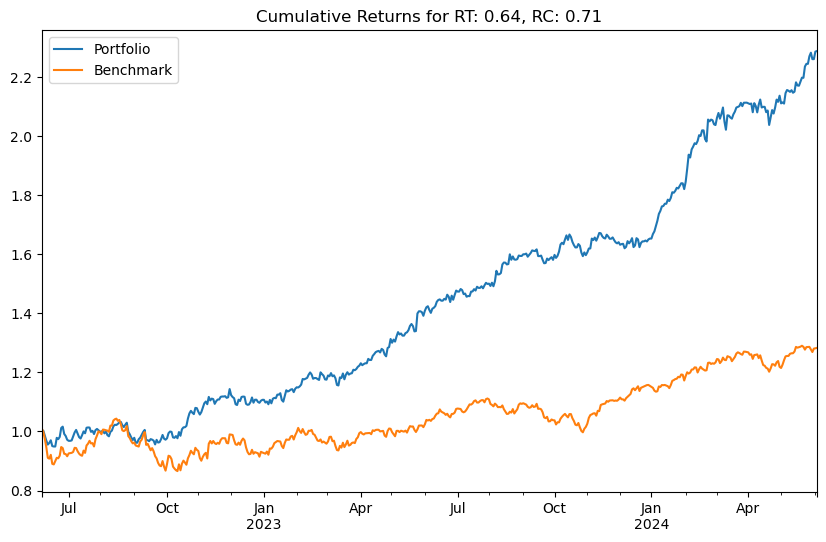

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


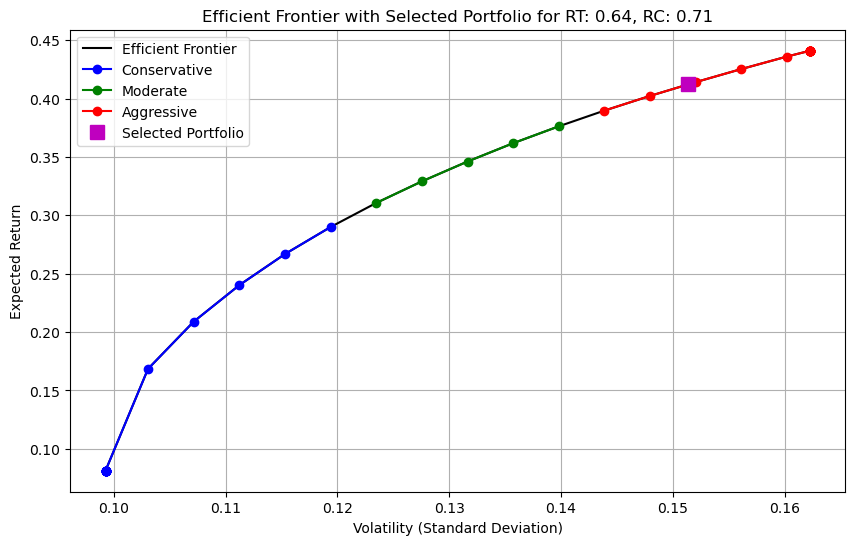

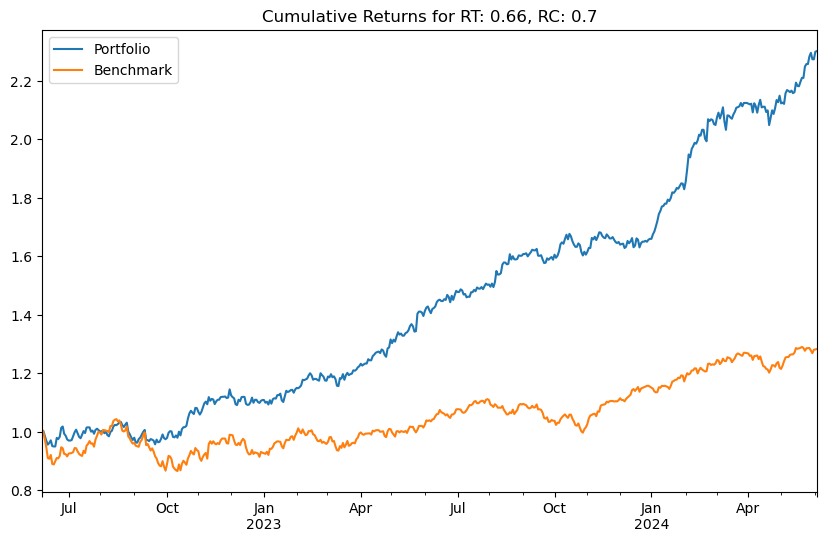

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


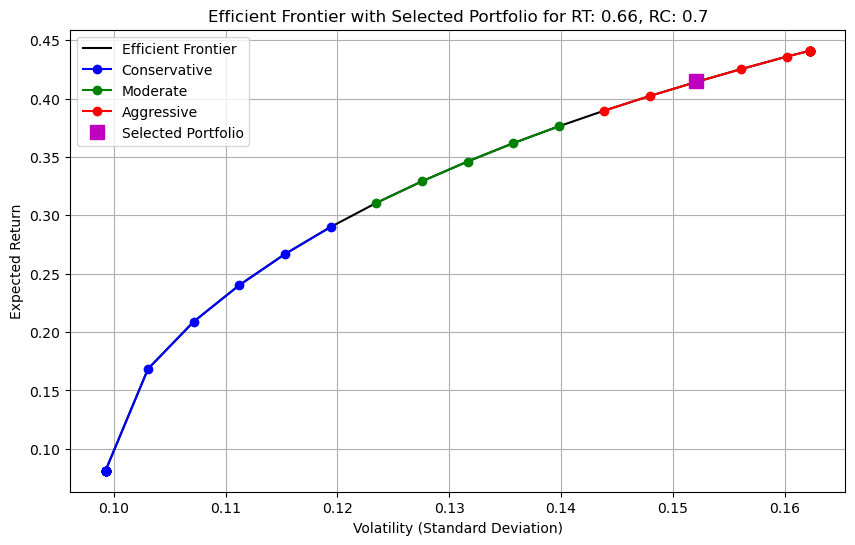

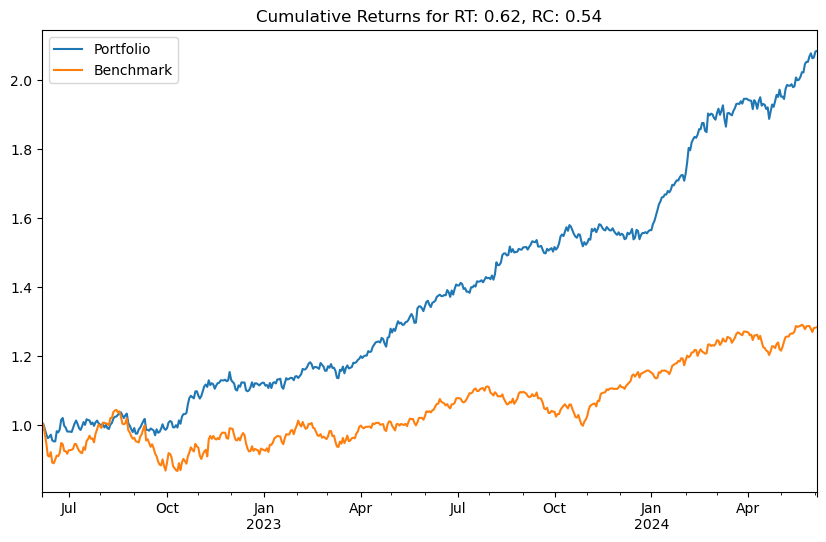

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


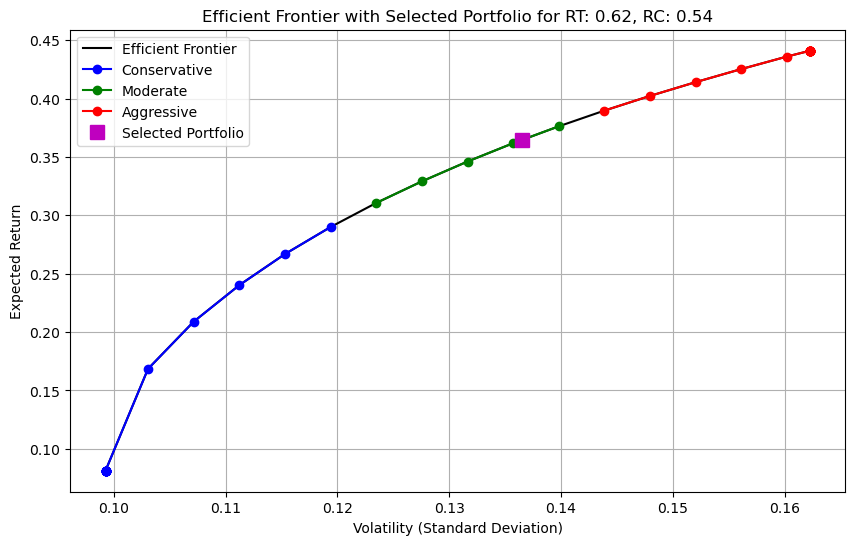

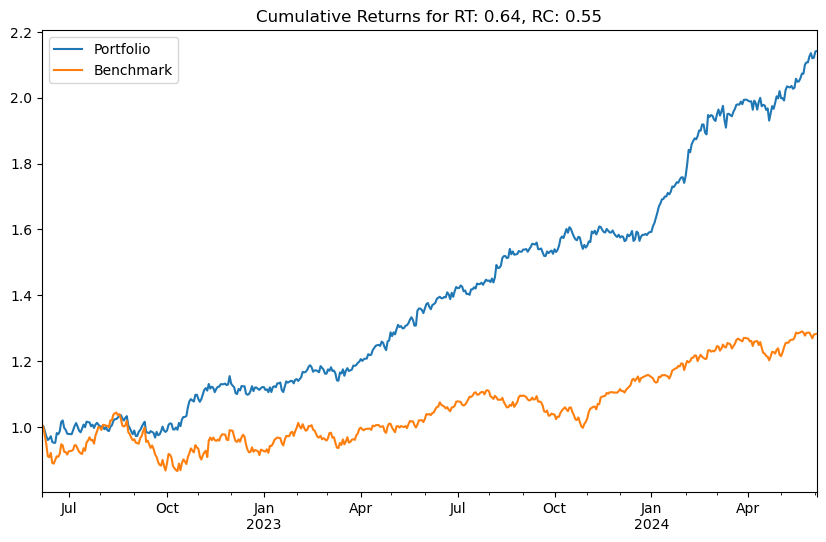

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


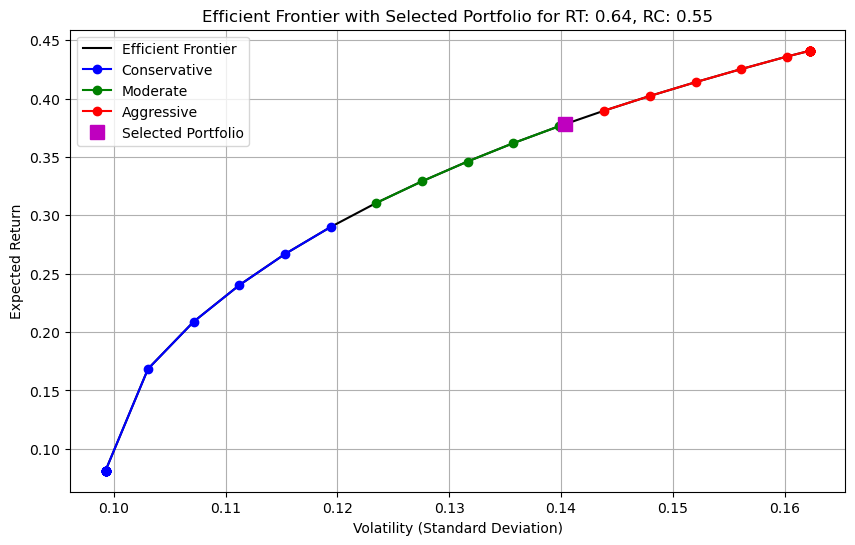

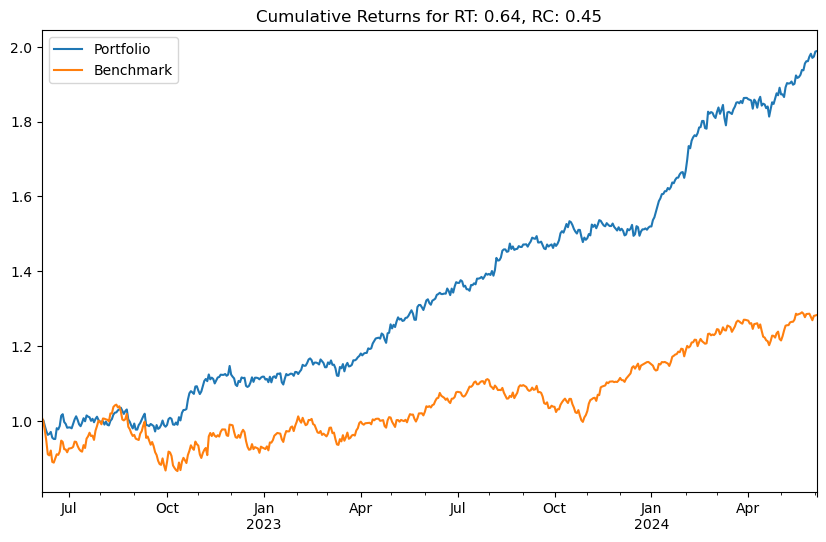

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


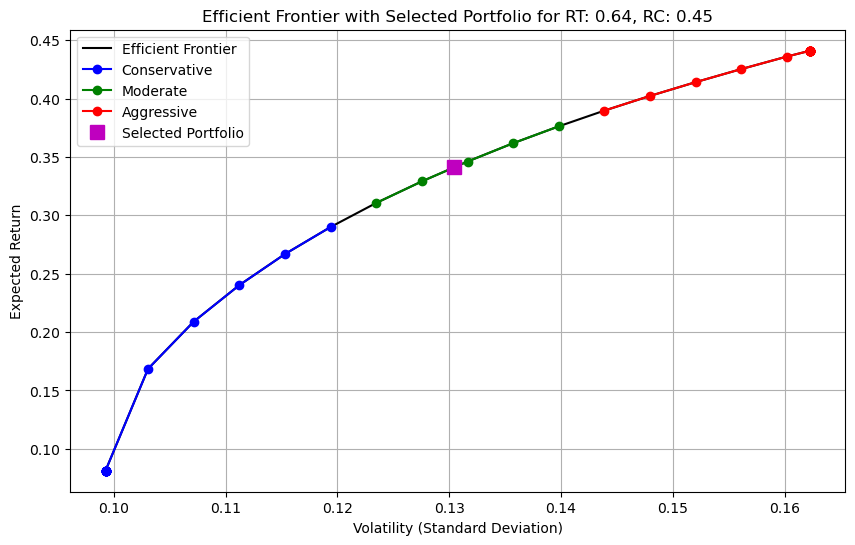

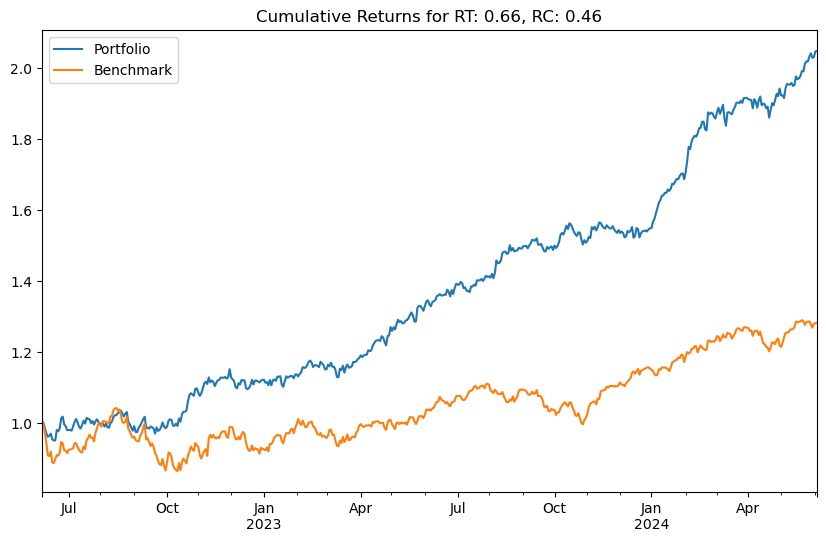

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


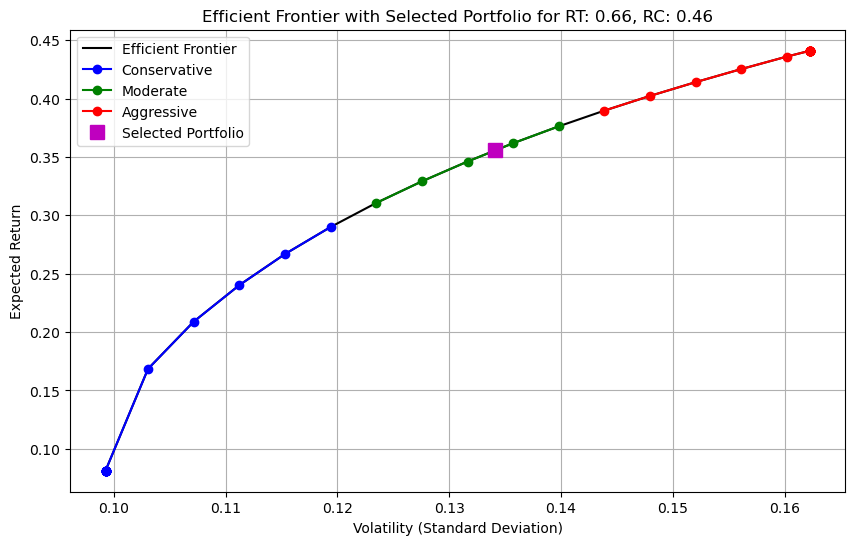

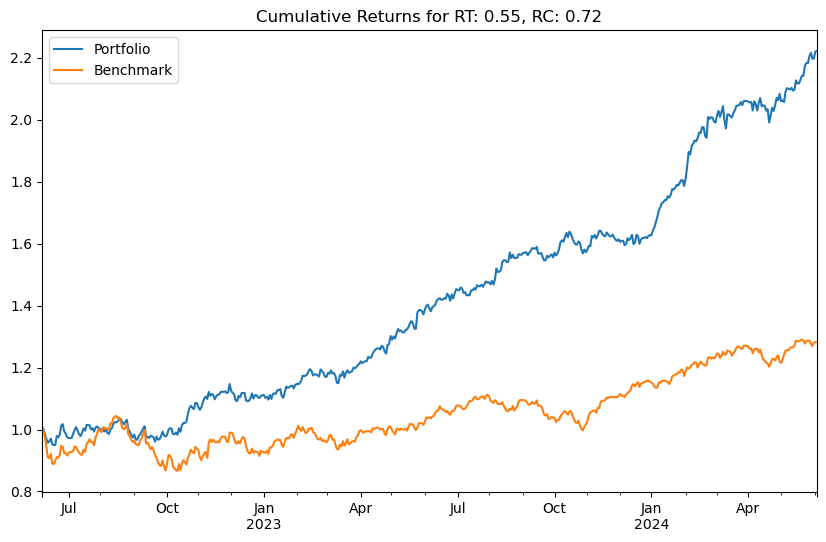

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


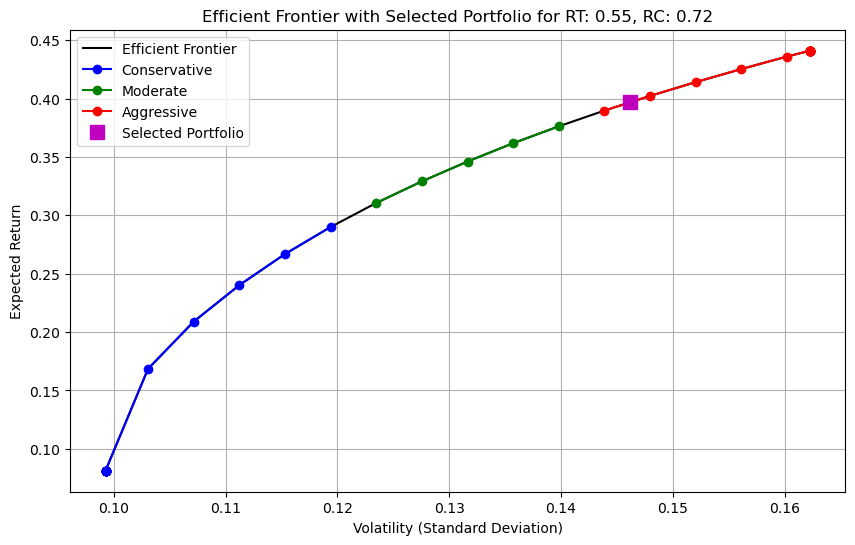

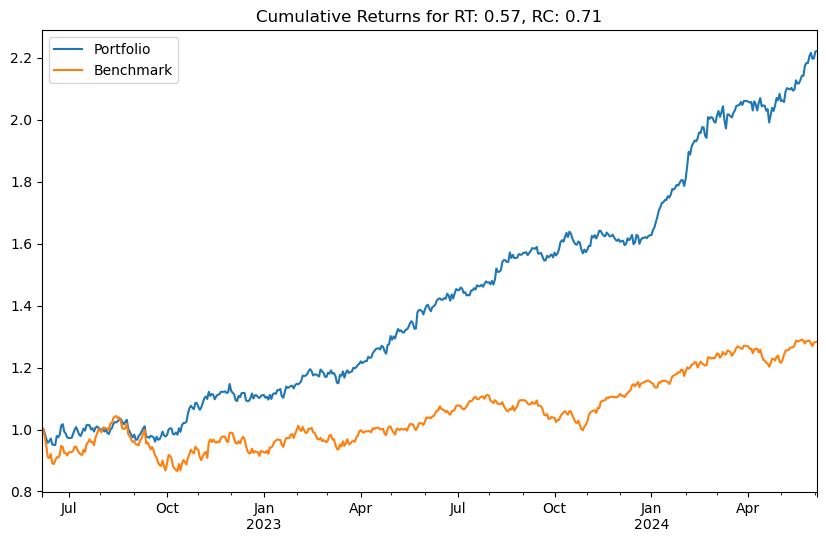

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


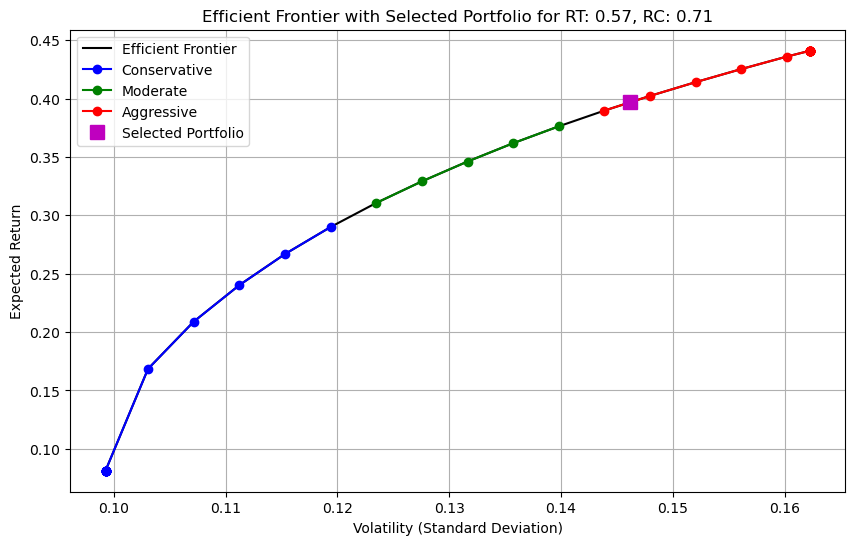

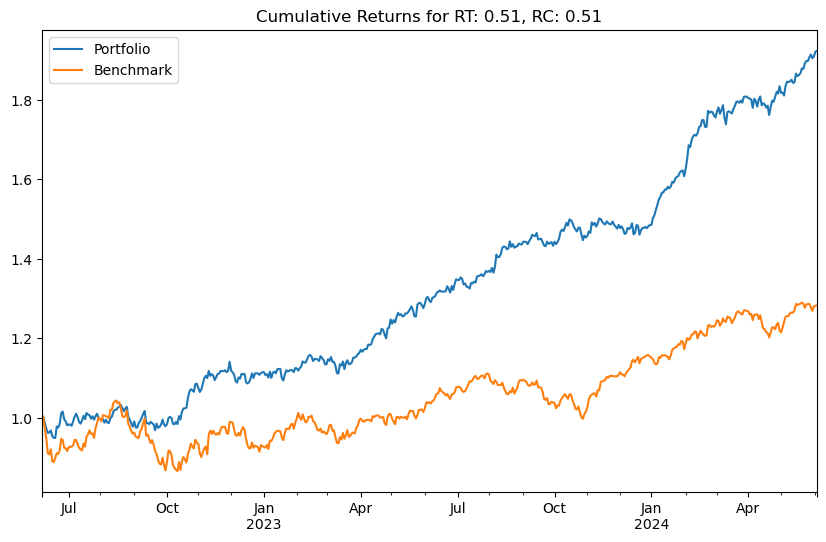

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


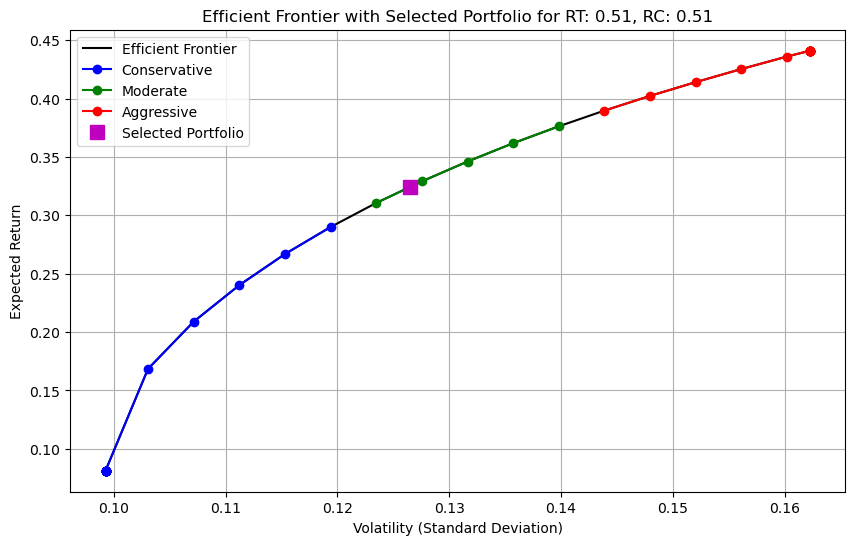

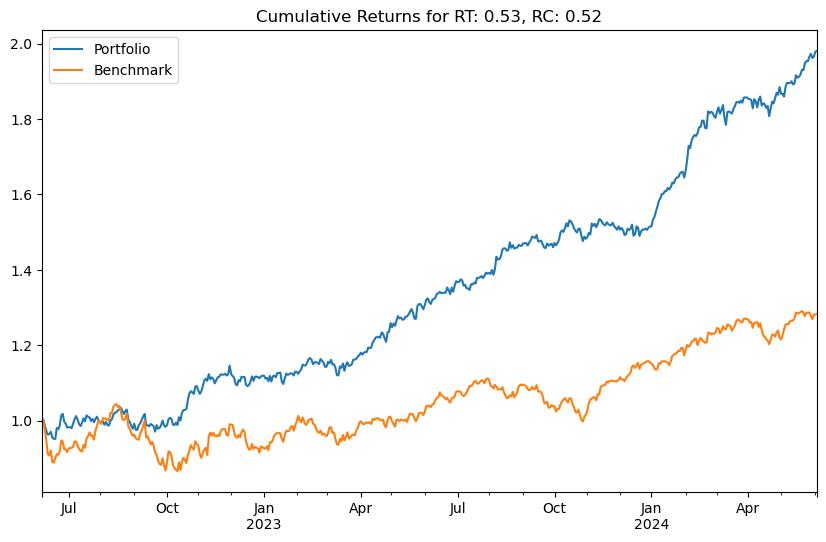

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


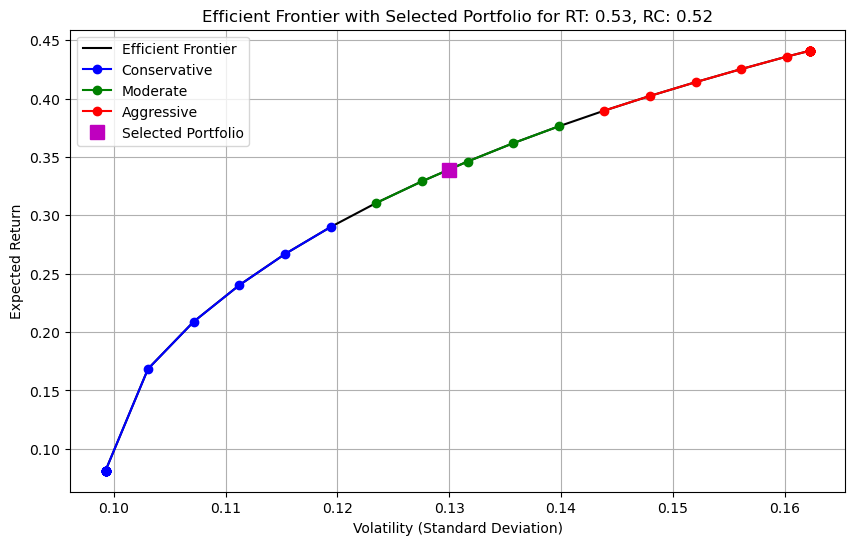

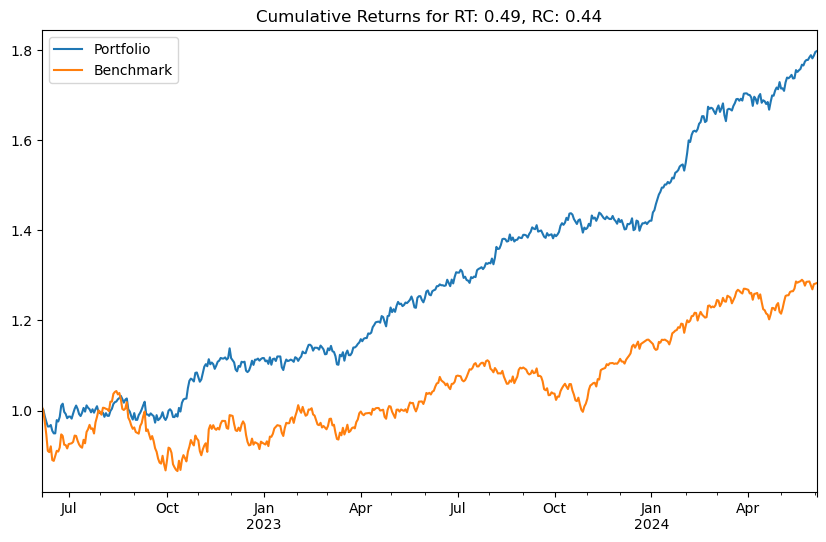

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


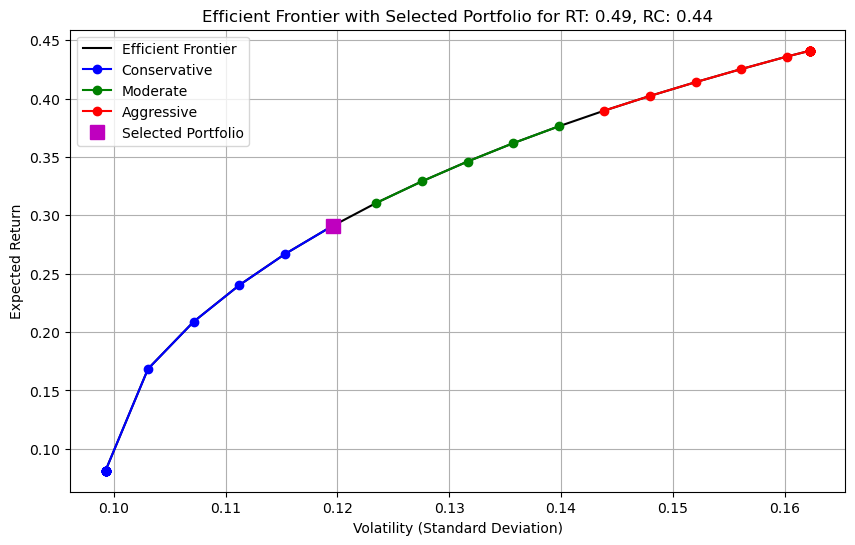

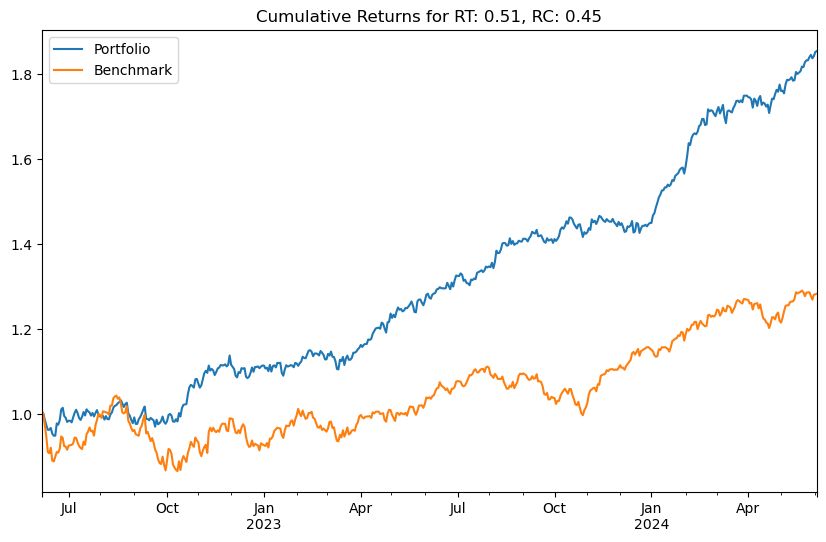

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


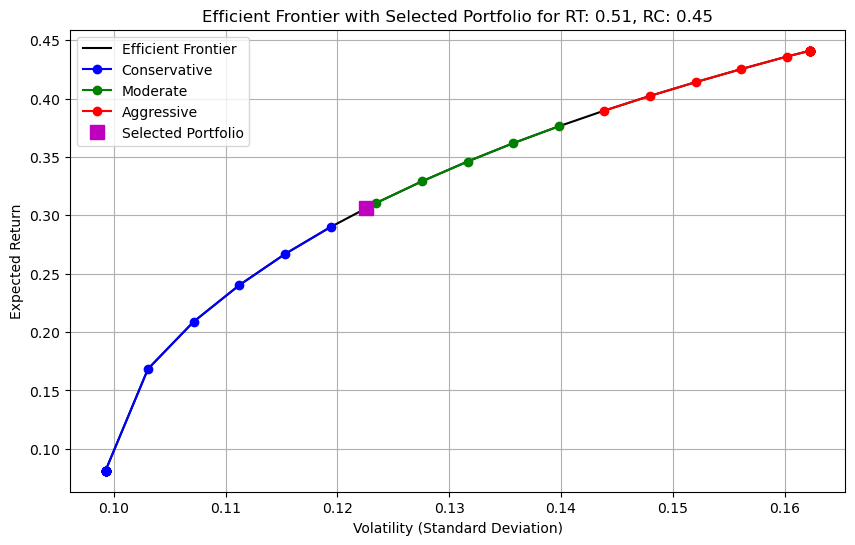

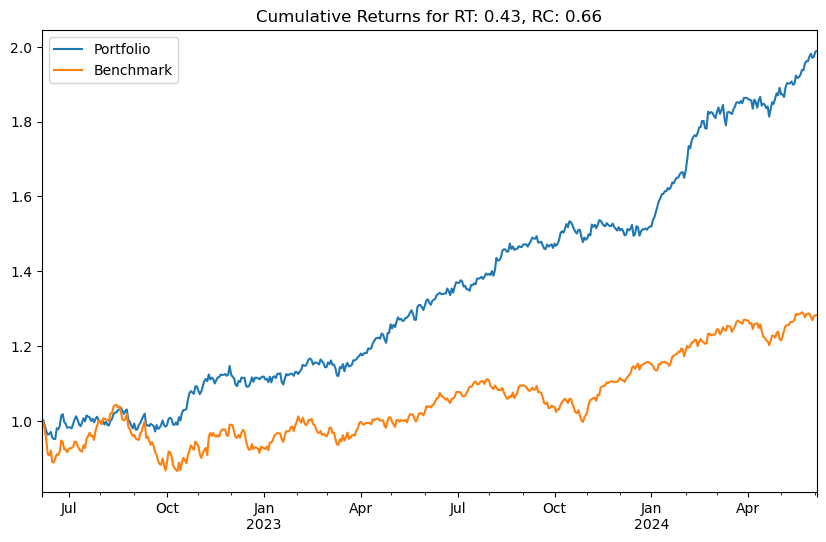

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


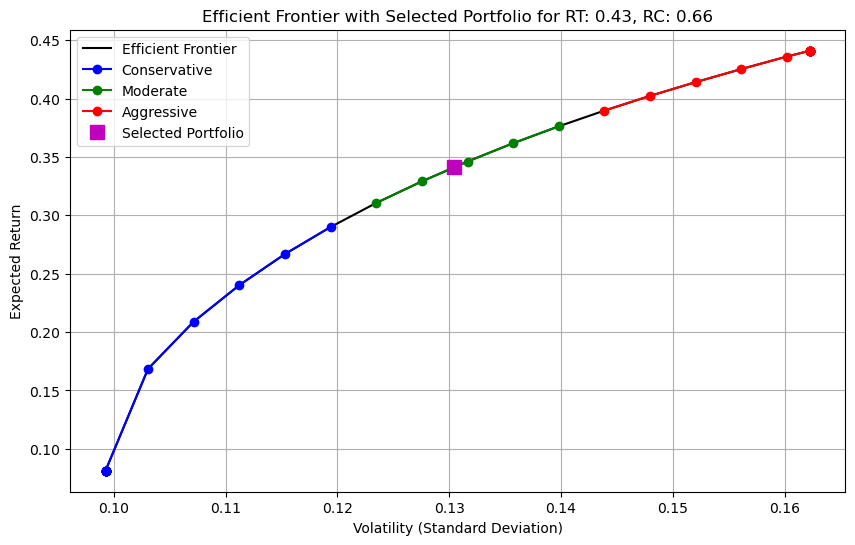

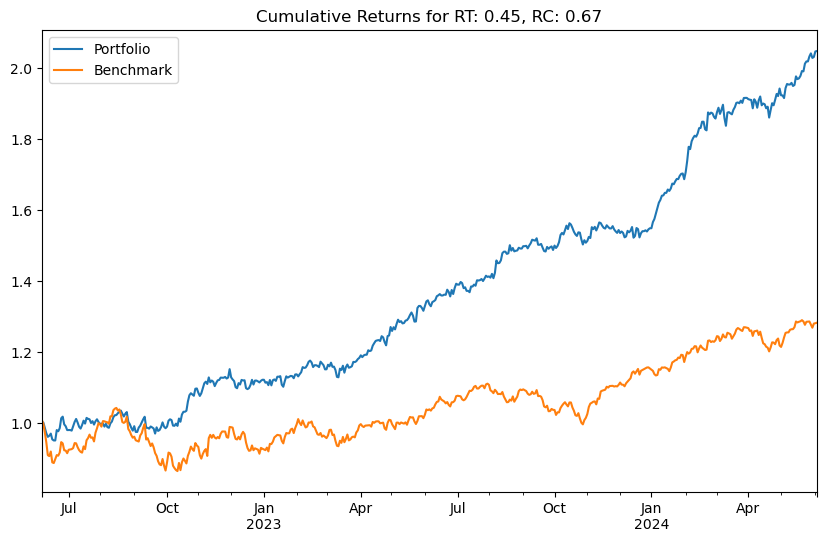

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


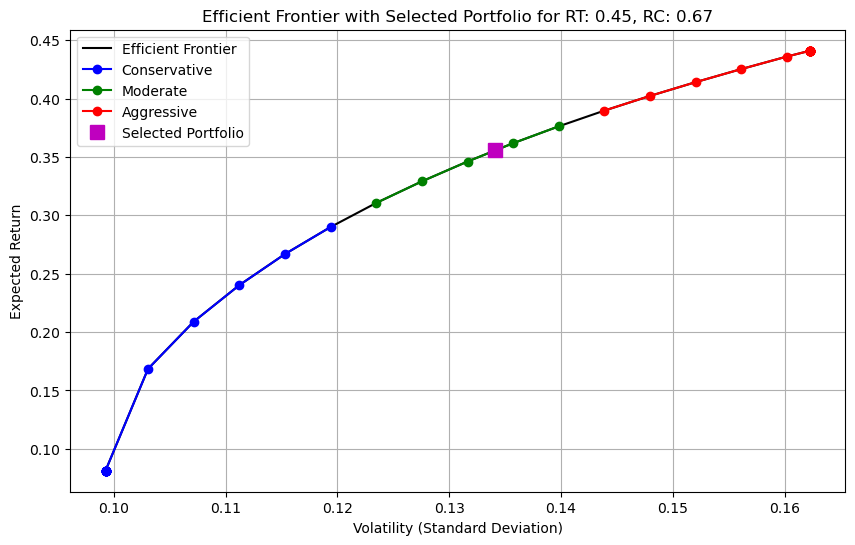

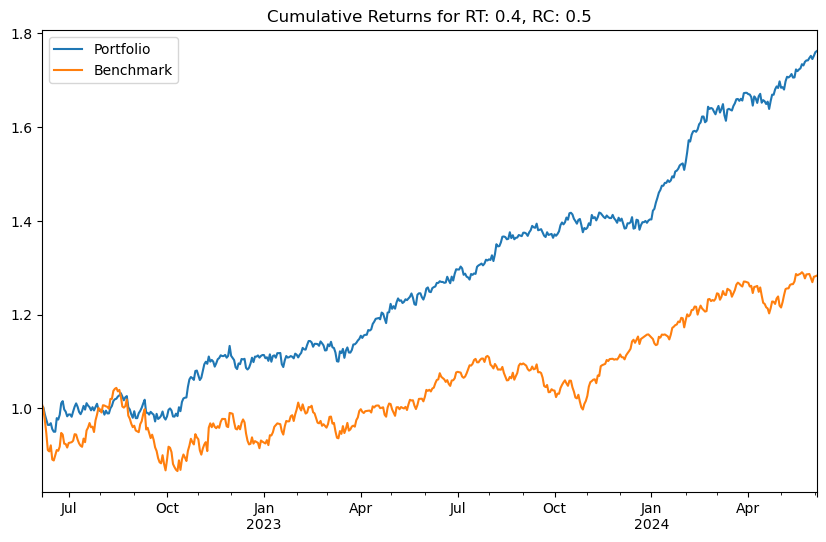

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


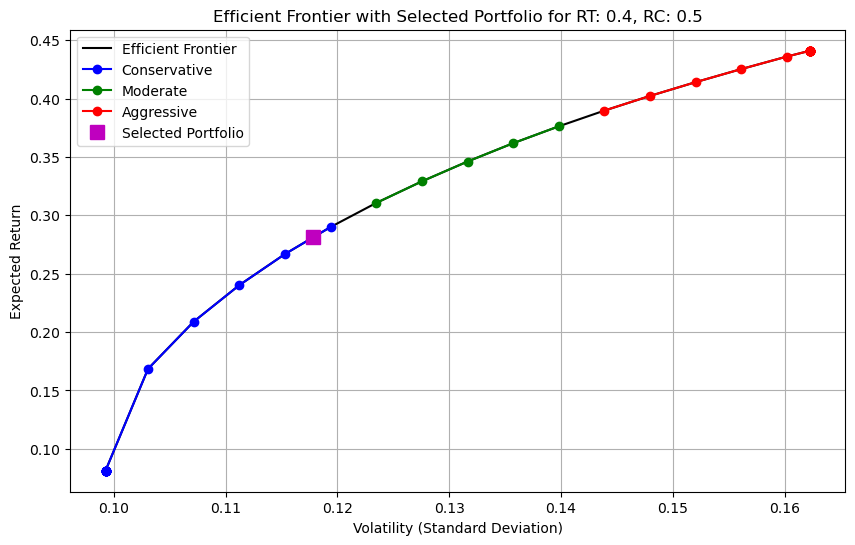

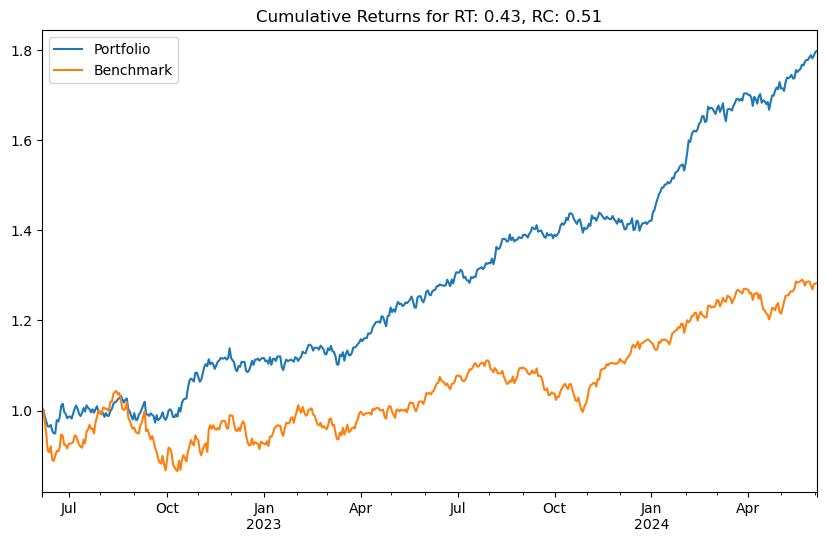

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


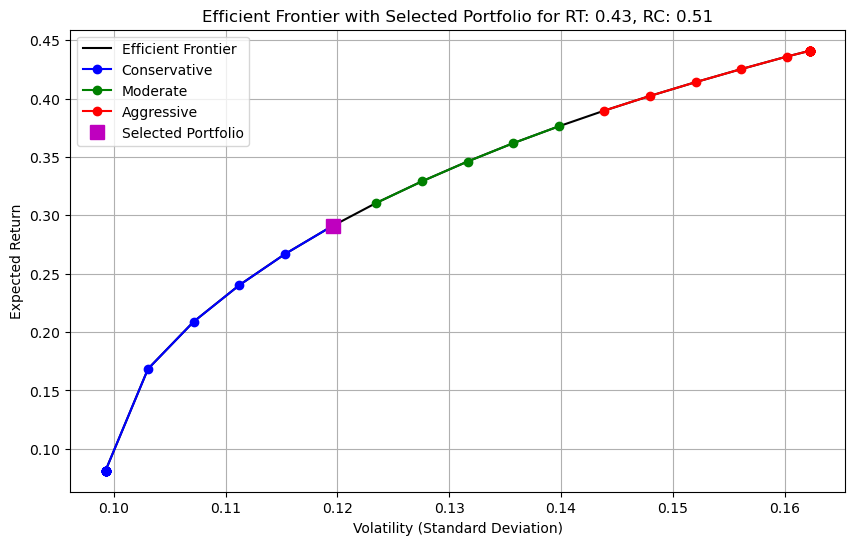

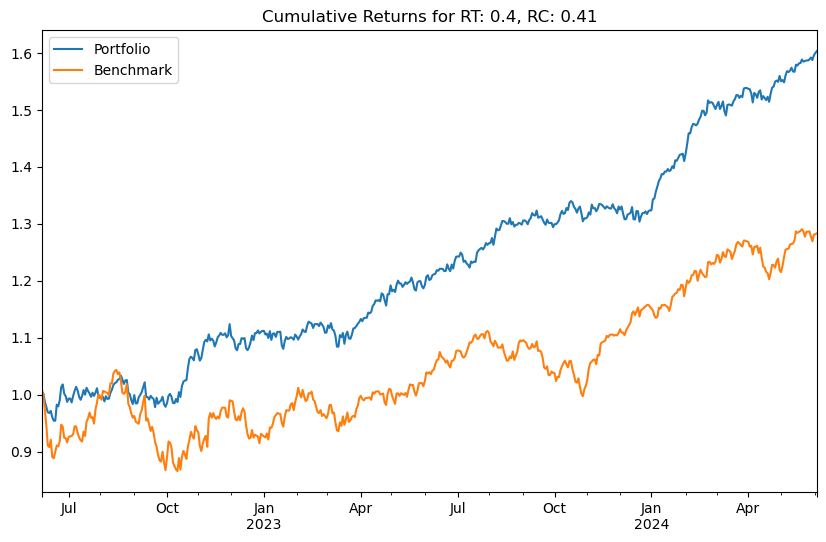

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


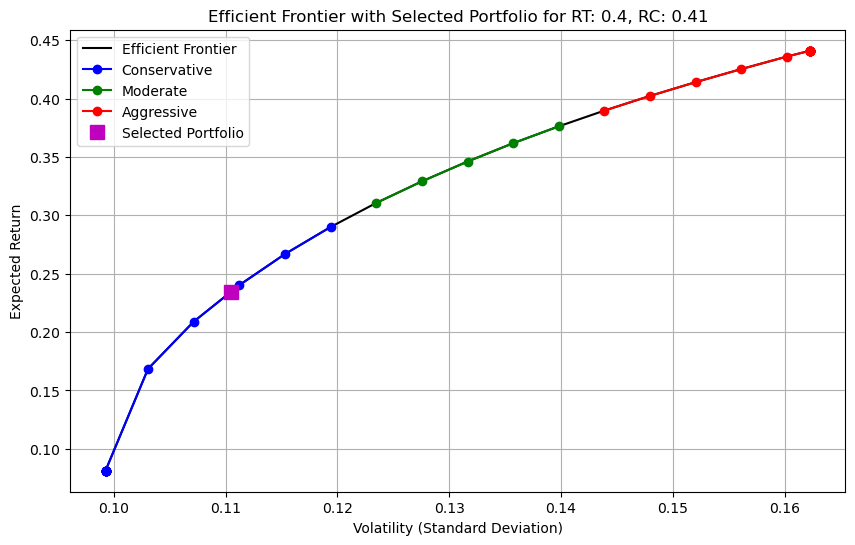

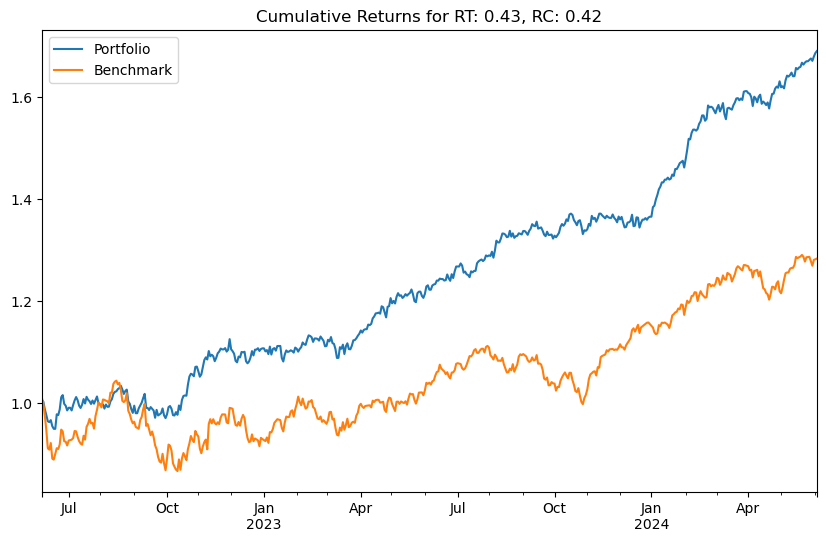

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


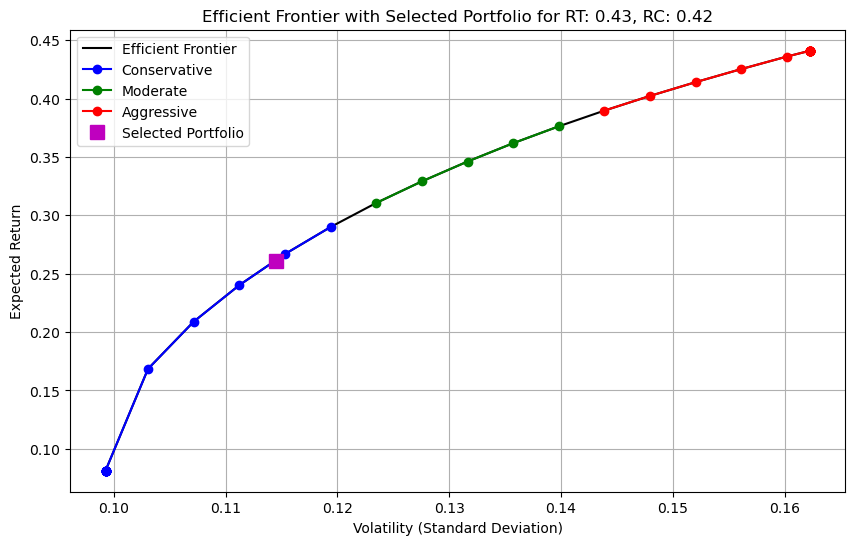

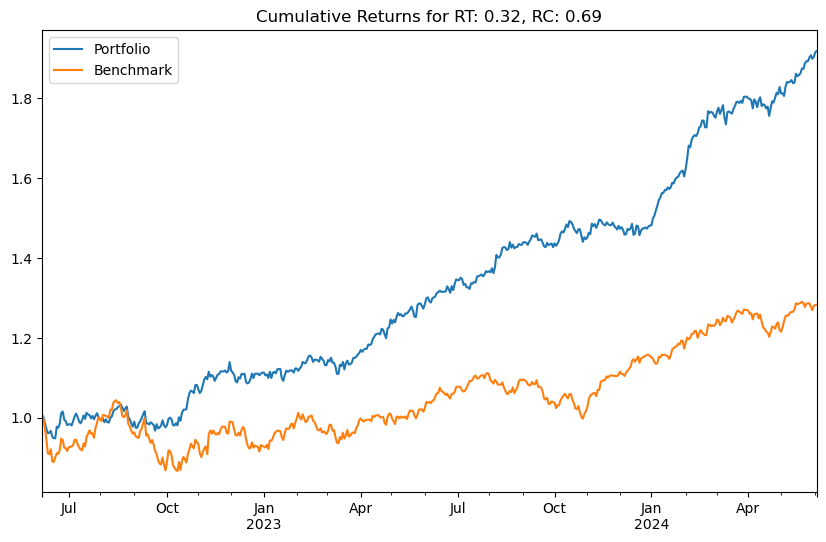

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


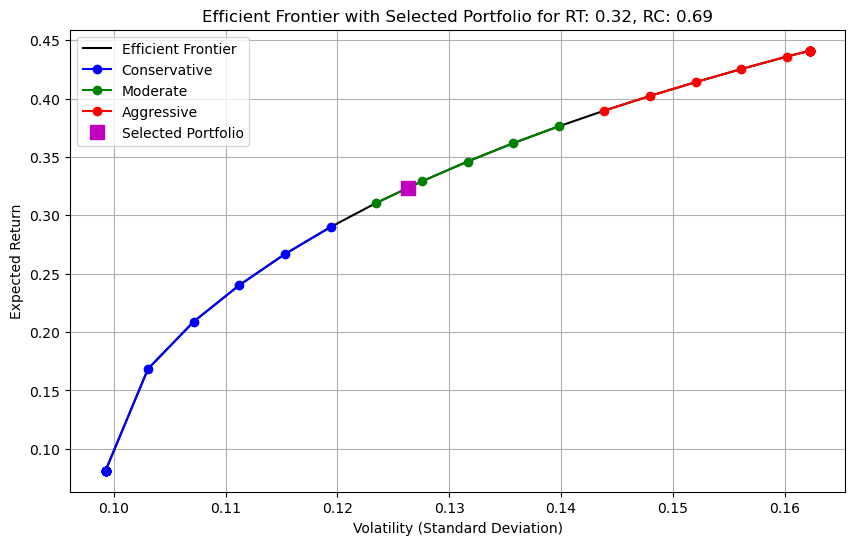

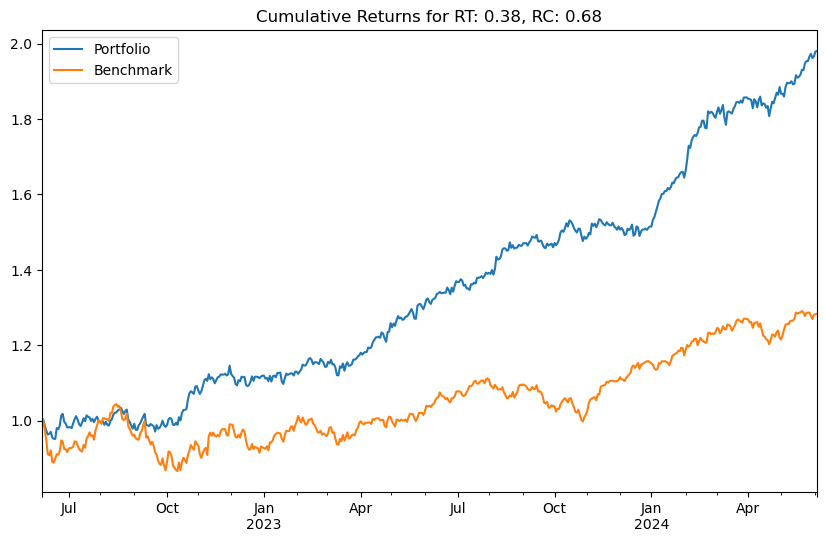

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


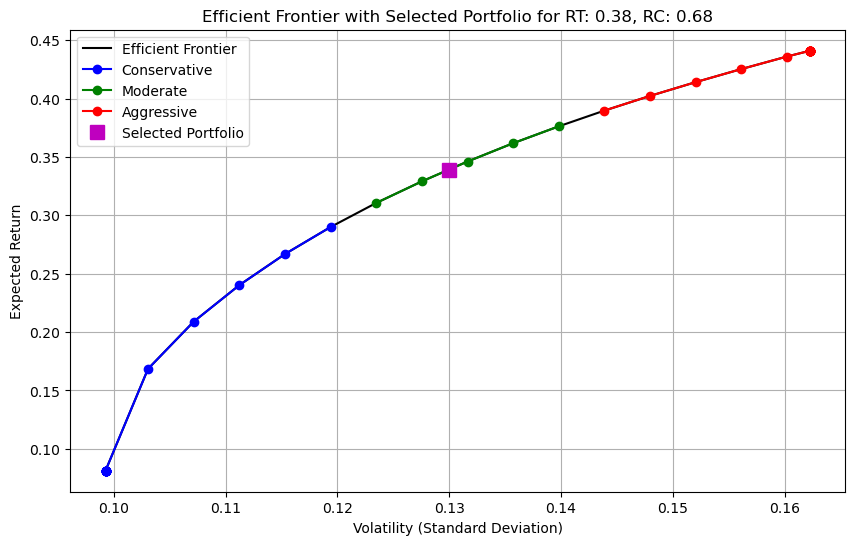

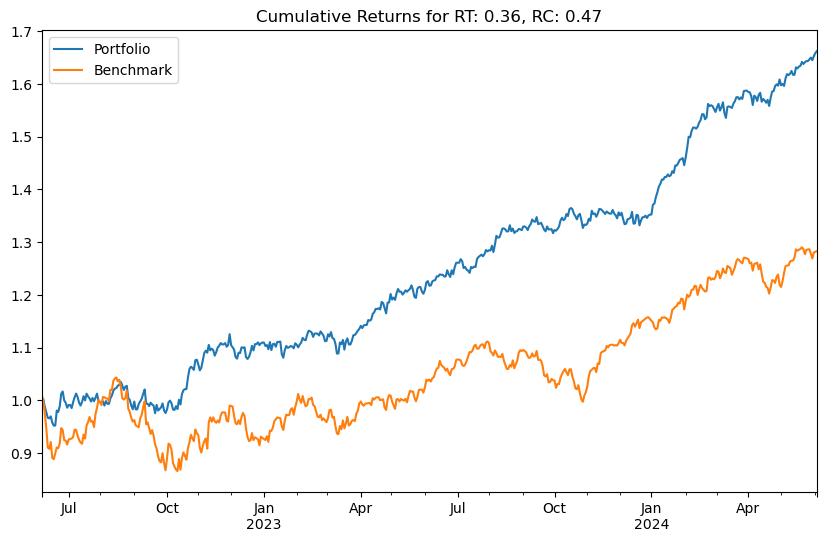

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


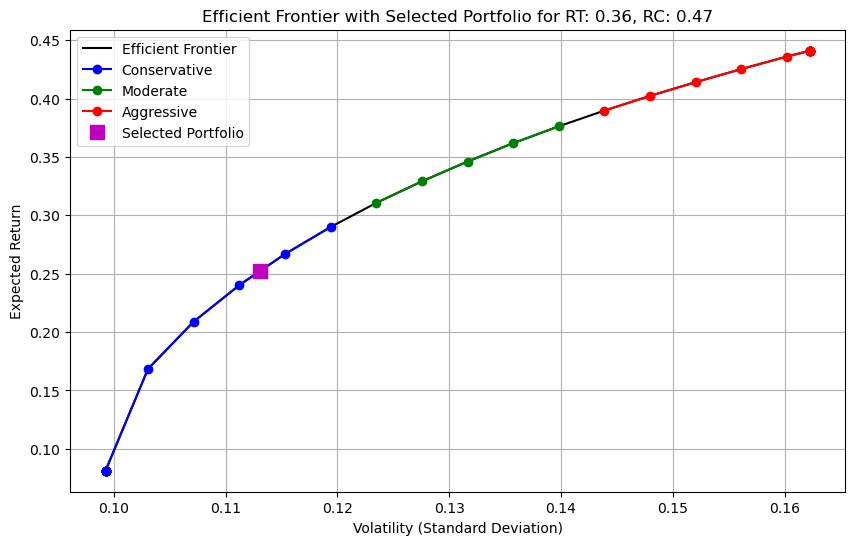

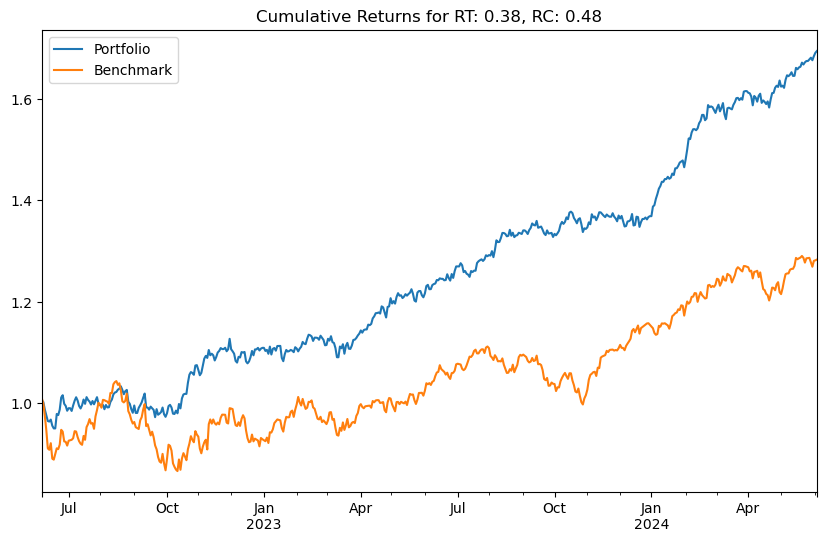

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


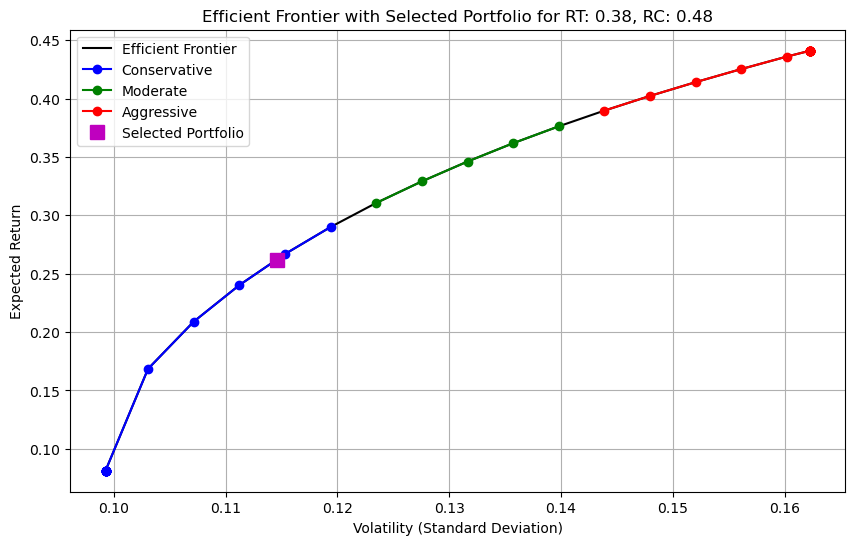

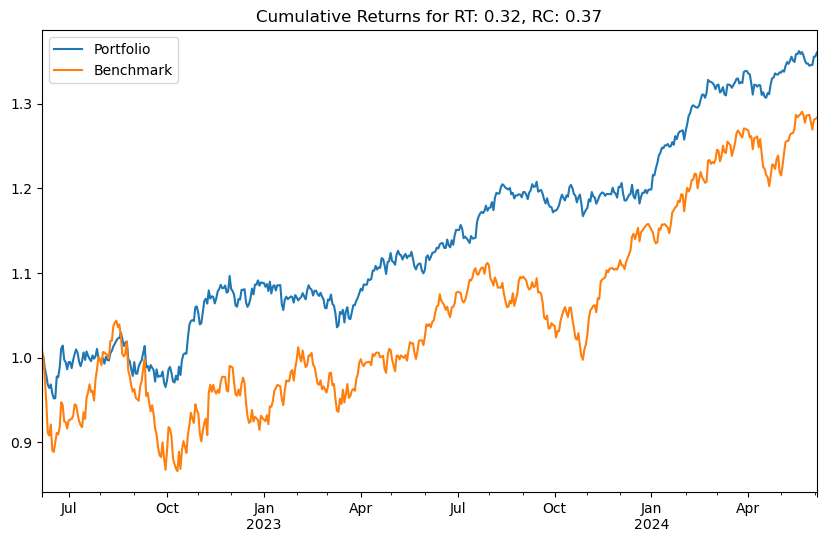

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


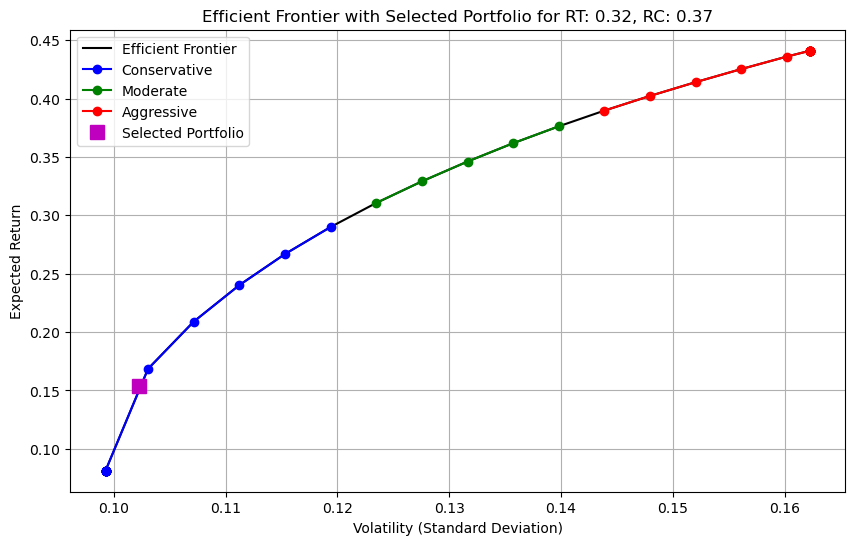

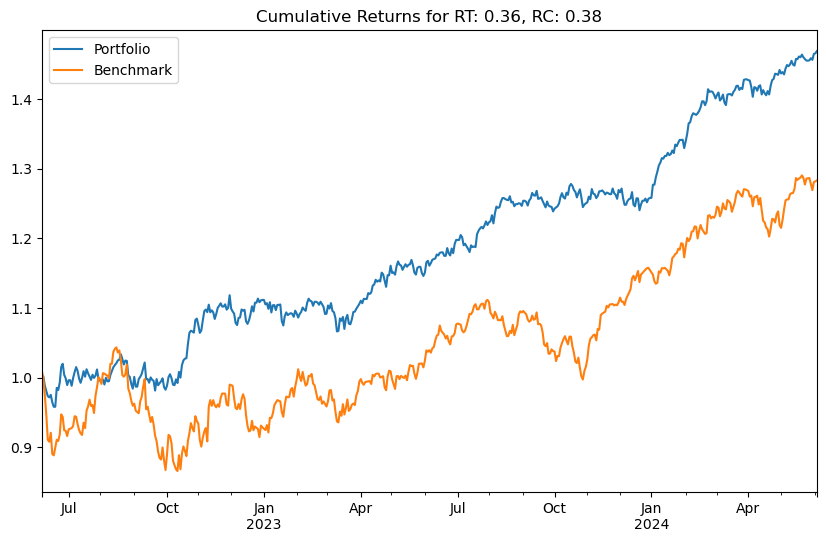

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


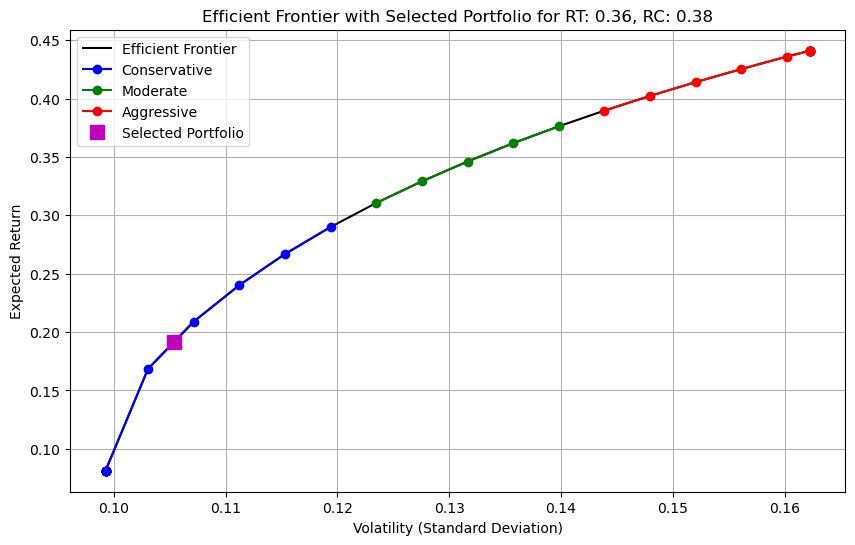

Overall results saved to 'overall_results.csv'
Portfolio allocations saved to 'portfolio_allocations.csv'
Portfolio array allocations saved to 'portfolio_array_allocations.csv'
Backtesting results saved to 'backtesting_results.csv'
Investment allocations saved to 'investment_allocations.csv'


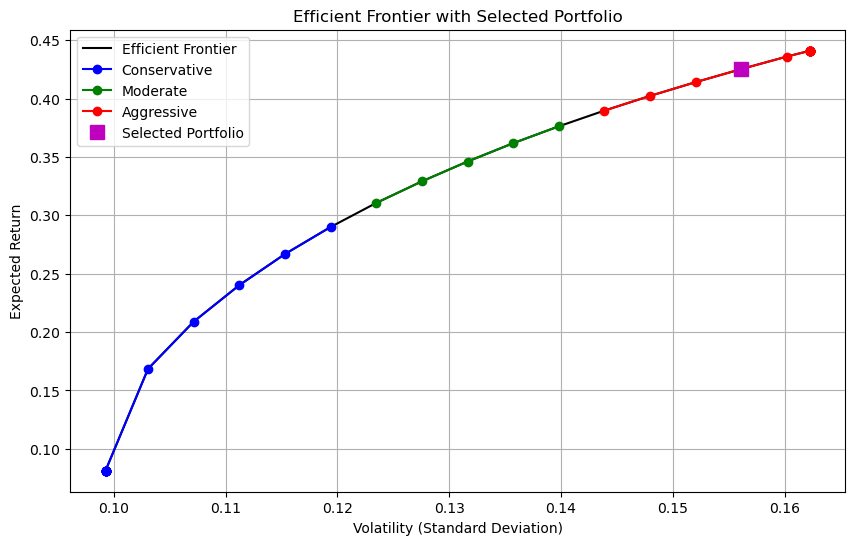

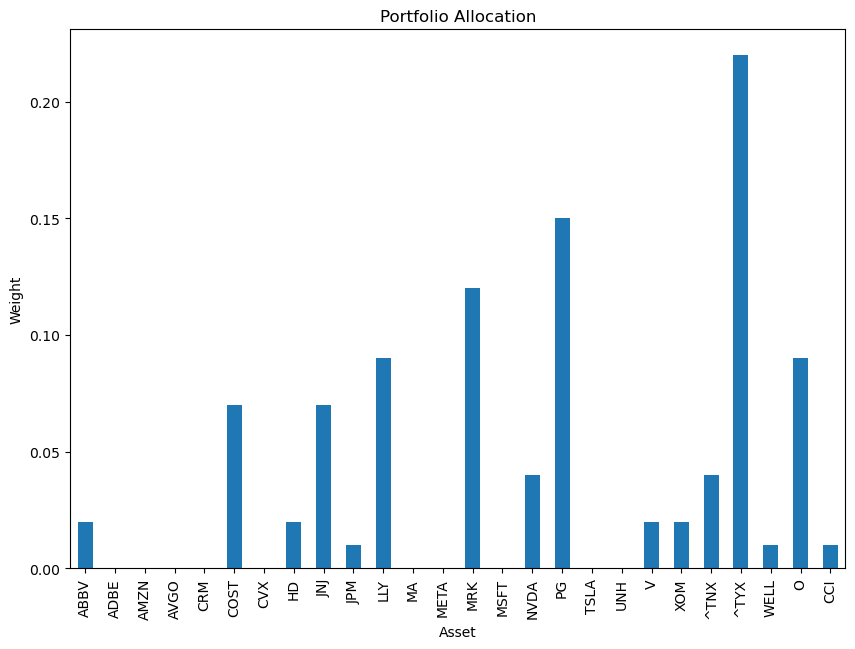

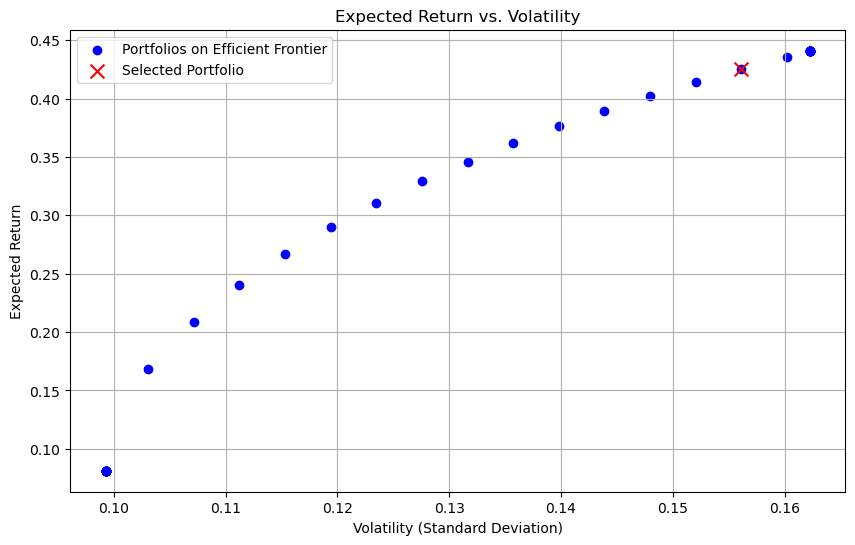

In [24]:
import numpy as np
import pandas as pd
import yahoo_fin.stock_info as si
from scipy.optimize import minimize
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Define the assets
stocks = ["AAPL", "ABBV", "ADBE", "AMZN", "AVGO", "BRK-B", "CRM", "COST", "CVX", "HD", 
          "JNJ", "JPM", "LLY", "MA", "META", "MRK", "MSFT", "NVDA", "PG", "TSLA", "UNH", "V", "XOM"]
bonds = ["^TNX", "^TYX"]
reits = ["WELL", "O", "CCI"]

assets = stocks + bonds + reits

# Set date range for the past 10 years
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y-%m-%d')

# Fetch historical data
data = {}
failed_assets = []
for asset in assets:
    try:
        print(f"Fetching data for {asset} from {start_date} to {end_date}")
        data[asset] = si.get_data(asset, start_date=start_date, end_date=end_date)['close']
        print(f"Fetched data for {asset}")
    except Exception as e:
        print(f"Failed to fetch data for {asset}: {e}")
        failed_assets.append(asset)

# Create a DataFrame from the fetched data
price_df = pd.DataFrame(data)

# Fill missing values by forward filling
price_df = price_df.ffill()

# Print the DataFrame to verify
print("Price DataFrame Head:")
print(price_df.head())
print("Price DataFrame Tail:")
print(price_df.tail())

# Drop columns with missing values
price_df = price_df.dropna(axis=1)

# Adjust the assets list based on successfully fetched data
valid_assets = price_df.columns.tolist()

# Ensure there are valid assets before proceeding
if len(valid_assets) == 0:
    raise ValueError("No valid assets fetched. Please check your asset list and data fetching process.")

# Calculate daily returns
returns_df = price_df.pct_change().dropna()
# Display the head and tail of returns_df to verify
print("Returns DataFrame Head:")
print(returns_df.head())
print("Returns DataFrame Tail:")
print(returns_df.tail())


# Calculate expected returns and covariance matrix
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Define normalization and composite risk profile calculation functions
def normalize_risk_tolerance_score(risk_tolerance_score):
    return risk_tolerance_score  # Assuming risk_tolerance_score is already between 0 and 1

def calculate_composite_risk_profile(risk_capacity, risk_tolerance_score):
    normalized_risk_tolerance_score = normalize_risk_tolerance_score(risk_tolerance_score)
    composite_risk_profile = (risk_capacity + normalized_risk_tolerance_score) / 2
    return composite_risk_profile

# def map_composite_risk_profile_to_target_risk(composite_risk_profile):
#     if composite_risk_profile <= 0.33:
#         # Conservative portfolio
#         min_risk_level = 0.05
#         max_risk_level = 0.10
#     elif composite_risk_profile <= 0.67:
#         # Balanced portfolio
#         min_risk_level = 0.10
#         max_risk_level = 0.15
#     else:
#         # Aggressive portfolio
#         min_risk_level = 0.15
#         max_risk_level = 0.30

#     return min_risk_level + (max_risk_level - min_risk_level) * (composite_risk_profile % 0.33)

def map_composite_risk_profile_to_target_risk(composite_risk_profile, min_risk_level=0.05, max_risk_level=0.20):
    return min_risk_level + (max_risk_level - min_risk_level) * composite_risk_profile
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * 252)
    return returns, std

def minimize_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# Objective function to maximize the Sharpe ratio and target risk level
def objective_function(weights, mean_returns, cov_matrix, risk_free_rate, target_risk):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = minimize_volatility(weights, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    penalty = abs(portfolio_volatility - target_risk)
    return -sharpe_ratio + penalty  # Negative to maximize Sharpe ratio and penalty to target risk level

# Get optimal weights based on the target risk level
def get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate, target_risk)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights must be 1
        {'type': 'ineq', 'fun': lambda x: target_risk - minimize_volatility(x, cov_matrix)}  # Ensure portfolio risk <= target risk
    )
    # bounds = tuple((0, 0.20) for asset in range(num_assets))  # Enforce diversification
    # Adjust bounds to ensure some allocation to REITs
    bounds = []
    for asset in assets:
        if asset in reits:
            bounds.append((0.01, 0.20))  # Ensure at least 1% allocation to REITs
        else:
            bounds.append((0, 0.20))
    bounds = tuple(bounds)

    result = minimize(objective_function, num_assets * [1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Define a function to calculate portfolios for a range of risk levels
def calculate_efficient_frontier(mean_returns, cov_matrix, risk_free_rate, num_portfolios=50):
    target_risks = np.linspace(0.05, 0.25, num_portfolios)  # Define a range of target risks
    portfolios = []

    for target_risk in target_risks:
        weights = get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk)
        returns, std = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        print(f"Target Risk: {target_risk}, Volatility: {std}, Return: {returns}")
        portfolios.append((std, returns, weights))

    return portfolios

# Define user information and risk tolerance
user_age = 30
investment_horizon = 20  # years
investment_amount = 10000  # in dollars
user_income = 75000  # annual income in dollars

# Define the RT and RC scores
risk_tolerance_scores = [0.72, 0.74, 0.70, 0.72, 0.70, 0.72, 0.64, 0.66, 0.62, 0.64, 0.64, 0.66, 0.55, 0.57, 0.51, 0.53, 0.49, 0.51, 0.43, 0.45, 0.40, 0.43, 0.40, 0.43, 0.32, 0.38, 0.36, 0.38, 0.32, 0.36]
risk_capacity_scores = [0.73, 0.67, 0.55, 0.56, 0.46, 0.47, 0.71, 0.70, 0.54, 0.55, 0.45, 0.46, 0.72, 0.71, 0.51, 0.52, 0.44, 0.45, 0.66, 0.67, 0.50, 0.51, 0.41, 0.42, 0.69, 0.68, 0.47, 0.48, 0.37, 0.38]

# Ensure both lists have the same length
assert len(risk_tolerance_scores) == len(risk_capacity_scores), "RT and RC lists must be of the same length."

# Prepare lists to store results
results = []
portfolio_results = []
portfolio_array_results = []
backtesting_results = []
investment_allocations = []

# Fetch benchmark data (e.g., S&P 500 index)
benchmark_data = si.get_data('SPY', start_date=start_date, end_date=end_date)['close']
benchmark_returns = benchmark_data.pct_change().dropna()


# Loop through each pair of risk tolerance and risk capacity scores
for rt_score, rc_score in zip(risk_tolerance_scores, risk_capacity_scores):
    # Calculate the composite risk profile
    composite_risk_profile = calculate_composite_risk_profile(rc_score, rt_score)
    
    # Map composite risk profile to target risk level
    target_risk = map_composite_risk_profile_to_target_risk(composite_risk_profile)
    
    # Get the optimal weights for the given target risk level
    optimal_weights = get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk)
    
    # Filter out assets with non-zero weights
    non_zero_weights = optimal_weights[optimal_weights > 0]
    non_zero_assets = np.array(valid_assets)[optimal_weights > 0]
    
    # Normalize the weights to sum up to 1 (100%)
    normalized_weights = non_zero_weights / np.sum(non_zero_weights)
    
    # Round the weights to two decimal places
    rounded_weights = np.round(normalized_weights, 2)
    
    # Adjust the weights to ensure they sum to 1 after rounding
    diff = 1.0 - np.sum(rounded_weights)
    rounded_weights[np.argmax(rounded_weights)] += diff
    
    # Create a DataFrame for the filtered and normalized portfolio
    optimal_portfolio = pd.DataFrame({'Asset': non_zero_assets, 'Weight': rounded_weights})
    
    # Calculate the expected return and volatility of the optimal portfolio
    optimal_return, optimal_volatility = portfolio_annualized_performance(
        rounded_weights, 
        mean_returns.loc[non_zero_assets], 
        cov_matrix.loc[non_zero_assets, non_zero_assets]
    )
    
    sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility
    
    # Store the overall results
    results.append({
        'Risk Tolerance Score': rt_score,
        'Risk Capacity Score': rc_score,
        'Composite Risk Profile': composite_risk_profile,
        'Target Risk Level': target_risk,
        'Expected Return': optimal_return,
        'Expected Volatility': optimal_volatility,
        'Sharpe Ratio': sharpe_ratio
    })
    
    # Store the portfolio results separately and exclude weights of 0
    portfolio_array = {'Stocks': [], 'Bonds': [], 'REITs': []}
    for asset, weight in zip(non_zero_assets, rounded_weights):
        if weight > 0:
            portfolio_results.append({
                'Risk Tolerance Score': rt_score,
                'Risk Capacity Score': rc_score,
                'Asset': asset,
                'Weight': weight
            })
            if asset in stocks:
                portfolio_array['Stocks'].append((asset, weight))
            elif asset in bonds:
                portfolio_array['Bonds'].append((asset, weight))
            elif asset in reits:
                portfolio_array['REITs'].append((asset, weight))
    
    portfolio_array_results.append({
        'Risk Tolerance Score': rt_score,
        'Risk Capacity Score': rc_score,
        'Portfolio': portfolio_array
    })

    # Calculate investment amount allocation
    total_stocks = sum(weight for asset, weight in portfolio_array['Stocks'])
    total_bonds = sum(weight for asset, weight in portfolio_array['Bonds'])
    total_reits = sum(weight for asset, weight in portfolio_array['REITs'])

    amount_stocks = total_stocks * investment_amount
    amount_bonds = total_bonds * investment_amount
    amount_reits = total_reits * investment_amount

    # Store investment allocations
    investment_allocations.append({
        'Risk Tolerance Score': rt_score,
        'Risk Capacity Score': rc_score,
        'Total Investment Amount': investment_amount,
        'Amount in Stocks': amount_stocks,
        'Amount in Bonds': amount_bonds,
        'Amount in REITs': amount_reits
    })

    # --- Start of Backtesting Section ---
    
    # Calculate portfolio returns based on optimized weights
    portfolio_returns = returns_df[non_zero_assets].dot(rounded_weights)
    
    # Calculate performance metrics
    metrics = calculate_performance_metrics(portfolio_returns, benchmark_returns, risk_free_rate)
    
    # Store the backtesting results
    backtesting_results.append({
        'Risk Tolerance Score': rt_score,
        'Risk Capacity Score': rc_score,
        'Annualized Return': metrics['Annualized Return'],
        'Benchmark Annualized Return': metrics['Benchmark Annualized Return'],
        'Volatility': metrics['Volatility'],
        'Benchmark Volatility': metrics['Benchmark Volatility'],
        'Sharpe Ratio': metrics['Sharpe Ratio'],
        'Benchmark Sharpe Ratio': metrics['Benchmark Sharpe Ratio'],
        'Max Drawdown': metrics['Max Drawdown'],
        'Alpha': metrics['Alpha'],
        'Beta': metrics['Beta']
    })
    
    # Plot cumulative returns
    plt.figure(figsize=(10, 6))
    (1 + portfolio_returns).cumprod().plot(label='Portfolio')
    (1 + benchmark_returns).cumprod().plot(label='Benchmark')
    plt.title(f'Cumulative Returns for RT: {rt_score}, RC: {rc_score}')
    plt.legend()
    plt.show()

    # Calculate the efficient frontier for each portfolio
    target_risks = np.linspace(0.05, 0.25, 50)  # Define a range of target risks
    efficient_frontier = []
    for target_risk in target_risks:
        weights = get_optimal_weights(mean_returns, cov_matrix, risk_free_rate, target_risk)
        returns, std = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        efficient_frontier.append((std, returns))

    # Split the efficient frontier into conservative, moderate, and aggressive sections based on dynamic thresholds
    min_volatility = min(p[0] for p in efficient_frontier)
    max_volatility = max(p[0] for p in efficient_frontier)
    volatility_range = max_volatility - min_volatility

    # Define dynamic thresholds
    conservative_threshold = min_volatility + volatility_range / 3
    moderate_threshold = min_volatility + 2 * volatility_range / 3

    # Allocate the portfolios dynamically
    conservative_portfolios = [p for p in efficient_frontier if p[0] <= conservative_threshold]
    moderate_portfolios = [p for p in efficient_frontier if conservative_threshold < p[0] <= moderate_threshold]
    aggressive_portfolios = [p for p in efficient_frontier if p[0] > moderate_threshold]

    # Ensure each section has at least one portfolio
    if not conservative_portfolios:
        conservative_portfolios.append(efficient_frontier[0])
    if not moderate_portfolios:
        moderate_portfolios.append(efficient_frontier[len(efficient_frontier)//2])
    if not aggressive_portfolios:
        aggressive_portfolios.append(efficient_frontier[-1])

    # Plot the efficient frontier with sections and the selected portfolio
    plt.figure(figsize=(10, 6))
    plt.plot([p[0] for p in efficient_frontier], [p[1] for p in efficient_frontier], 'k-', label='Efficient Frontier')
    plt.plot([p[0] for p in conservative_portfolios], [p[1] for p in conservative_portfolios], 'bo-', label='Conservative')
    plt.plot([p[0] for p in moderate_portfolios], [p[1] for p in moderate_portfolios], 'go-', label='Moderate')
    plt.plot([p[0] for p in aggressive_portfolios], [p[1] for p in aggressive_portfolios], 'ro-', label='Aggressive')
    plt.plot(optimal_volatility, optimal_return, 'ms', markersize=10, label='Selected Portfolio')  # Highlight the selected portfolio

    plt.title(f'Efficient Frontier with Selected Portfolio for RT: {rt_score}, RC: {rc_score}')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Convert results to DataFrames
results_df = pd.DataFrame(results)
portfolio_df = pd.DataFrame(portfolio_results)
portfolio_array_df = pd.DataFrame(portfolio_array_results)
backtesting_df = pd.DataFrame(backtesting_results)
investment_allocations_df = pd.DataFrame(investment_allocations)

# Format DataFrame to display numbers with two decimal places
results_df = results_df.round(2)
portfolio_df = portfolio_df.round(2)
portfolio_array_df = portfolio_array_df.round(2)
backtesting_df = backtesting_df.round(2)
investment_allocations_df = investment_allocations_df.round(2)

# Save to CSV files
results_df.to_csv('overall_results.csv', index=False)
portfolio_df.to_csv('portfolio_allocations.csv', index=False)
portfolio_array_df.to_csv('portfolio_array_allocations.csv', index=False)
backtesting_df.to_csv('backtesting_results.csv', index=False)
investment_allocations_df.to_csv('investment_allocations.csv', index=False)

print("Overall results saved to 'overall_results.csv'")
print("Portfolio allocations saved to 'portfolio_allocations.csv'")
print("Portfolio array allocations saved to 'portfolio_array_allocations.csv'")
print("Backtesting results saved to 'backtesting_results.csv'")
print("Investment allocations saved to 'investment_allocations.csv'")

# Categorize the assets based on their types
portfolio_stocks = []
portfolio_bonds = []
portfolio_reits = []

for asset, weight in zip(non_zero_assets, rounded_weights):
    if asset in stocks:
        portfolio_stocks.append((asset, weight))
    elif asset in bonds:
        portfolio_bonds.append((asset, weight))
    elif asset in reits:
        portfolio_reits.append((asset, weight))

# Display the user's portfolio in array format
user_portfolio = {
    "Stocks": portfolio_stocks,
    "Bonds": portfolio_bonds,
    "REITs": portfolio_reits
}

# Calculate the total amount allocated to each asset class
total_stocks = sum(weight for asset, weight in user_portfolio["Stocks"])
total_bonds = sum(weight for asset, weight in user_portfolio["Bonds"])
total_reits = sum(weight for asset, weight in user_portfolio["REITs"])

amount_stocks = total_stocks * investment_amount
amount_bonds = total_bonds * investment_amount
amount_reits = total_reits * investment_amount

# print("User's Portfolio:")
# print("Stocks:", user_portfolio["Stocks"])
# print("Bonds:", user_portfolio["Bonds"])
# print("REITs:", user_portfolio["REITs"])

# print("\nInvestment Amount Allocation:")
# print(f"Total Investment Amount: ${investment_amount}")
# print(f"Amount in Stocks: ${amount_stocks:.2f}")
# print(f"Amount in Bonds: ${amount_bonds:.2f}")
# print(f"Amount in REITs: ${amount_reits:.2f}")

# Split the efficient frontier into conservative, moderate, and aggressive sections based on dynamic thresholds
min_volatility = min(p[0] for p in efficient_frontier)
max_volatility = max(p[0] for p in efficient_frontier)
volatility_range = max_volatility - min_volatility

# Define dynamic thresholds
conservative_threshold = min_volatility + volatility_range / 3
moderate_threshold = min_volatility + 2 * volatility_range / 3

# Allocate the portfolios dynamically
conservative_portfolios = [p for p in efficient_frontier if p[0] <= conservative_threshold]
moderate_portfolios = [p for p in efficient_frontier if conservative_threshold < p[0] <= moderate_threshold]
aggressive_portfolios = [p for p in efficient_frontier if p[0] > moderate_threshold]

# Ensure each section has at least one portfolio
if not conservative_portfolios:
    conservative_portfolios.append(efficient_frontier[0])
if not moderate_portfolios:
    moderate_portfolios.append(efficient_frontier[len(efficient_frontier)//2])
if not aggressive_portfolios:
    aggressive_portfolios.append(efficient_frontier[-1])

# Extract weights for the first portfolio in each section
conservative_start = conservative_portfolios[0]
moderate_start = moderate_portfolios[0]
aggressive_start = aggressive_portfolios[0]

# Plot the efficient frontier with sections and the selected portfolio
plt.figure(figsize=(10, 6))
plt.plot([p[0] for p in efficient_frontier], [p[1] for p in efficient_frontier], 'k-', label='Efficient Frontier')
plt.plot([p[0] for p in conservative_portfolios], [p[1] for p in conservative_portfolios], 'bo-', label='Conservative')
plt.plot([p[0] for p in moderate_portfolios], [p[1] for p in moderate_portfolios], 'go-', label='Moderate')
plt.plot([p[0] for p in aggressive_portfolios], [p[1] for p in aggressive_portfolios], 'ro-', label='Aggressive')
plt.plot(selected_portfolio[0], selected_portfolio[1], 'ms', markersize=10, label='Selected Portfolio')  # Highlight the selected portfolio

plt.title('Efficient Frontier with Selected Portfolio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

# # Plot historical prices
# price_df.plot(figsize=(14, 7), title='Historical Prices of Assets')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.show()

# # Plot returns
# returns_df.plot(kind='hist', bins=50, alpha=0.6, figsize=(14, 7), title='Histogram of Daily Returns')
# plt.xlabel('Daily Return')
# plt.show()

# Alternatively, a bar chart
optimal_portfolio.plot(kind='bar', x='Asset', y='Weight', legend=False, figsize=(10, 7), title='Portfolio Allocation')
plt.xlabel('Asset')
plt.ylabel('Weight')
plt.show()


# Plot the expected return and volatility of the selected portfolio
plt.figure(figsize=(10, 6))
plt.scatter([p[0] for p in efficient_frontier], [p[1] for p in efficient_frontier], c='blue', marker='o', label='Portfolios on Efficient Frontier')
plt.scatter(selected_portfolio[0], selected_portfolio[1], c='red', marker='x', s=100, label='Selected Portfolio')  # Highlight the selected portfolio

plt.title('Expected Return vs. Volatility')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

